# Batch (parallel) Demand Forecasting using Prophet, ARIMA, and Ray Tune

**Batch training** and tuning are common tasks in machine learning use-cases. They require training simple models, on data batches, typcially corresponding to different locations, products, etc. Batch training can take less time to process all the data at once, but only if those batches can run in parallel!

This notebook showcases how to conduct batch training using forecast algorithms [Prophet](https://github.com/facebook/prophet) and [ARIMA](https://github.com/Nixtla/statsforecast). **Prophet** is a popular open-source library developed by Facebook and designed for automatic forecasting of univariate time series data. **ARIMA** is an older, well-known algorithm for forecasting univariate time series at less fine-grained detail than Prophet.

![Batch training diagram](../../data/examples/images/batch-training.svg)

For the data, we will use the [NYC Taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). This popular tabular dataset contains historical taxi pickups by timestamp and location in NYC.

For the training, we will train a separate forecasting model to predict #pickups at each location in NYC at daily level for the next 28 days. Specifically, we will use the `pickup_location_id` column in the dataset to group the dataset into data batches. Then we will conduct an experiment for each location, to find the best either Prophet or ARIMA model, per location.

# Contents

In this this tutorial, you will learn how to:
 1. [Define how to load and prepare Parquet data](#prepare_data2)
 2. [Define a Trainable (callable) function](#define_trainable2)
 3. [Run batch training and inference with Ray Tune](#run_tune_search2)
 4. [Load a model from checkpoint](#load_checkpoint2)
 5. [Create a forecast from restored checkpoint model](#create_prediction2)


# Walkthrough

```{tip}
Prerequisite for this notebook: Read the [Key Concepts](https://docs.ray.io/en/latest/tune/key-concepts.html) page for Ray Tune.
```

Let us start by importing a few required libraries, including open-source [Ray](https://github.com/ray-project/ray) itself!

In [1]:
!python --version
import os
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
from typing import Tuple, List, Union, Optional, Callable
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np

print(f"numpy: {np.__version__}")
import matplotlib.pyplot as plt

%matplotlib inline
import scipy

print(f"scipy: {scipy.__version__}")
import pyarrow
import pyarrow.parquet as pq
import pyarrow.dataset as pds

print(f"pyarrow: {pyarrow.__version__}")

Python 3.8.13
Number of CPUs in this system: 8
numpy: 1.21.6
scipy: 1.9.3
pyarrow: 10.0.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-03 19:16:44,879	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-03 19:16:44,881	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 172.31.207.227:9031...
2023-01-03 19:16:44,927	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard 


Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://console.anyscale-staging.com/api/v2/sessions/ses_b5q8xHd42BTdukSgFqTxejLT/services?redirect_to=dashboard


In [3]:
print(ray.cluster_resources())

{'CPU': 24.0, 'object_store_memory': 27587783884.0, 'node:172.31.219.244': 1.0, 'memory': 66366973543.0, 'node:172.31.207.227': 1.0}


In [4]:
# import forecasting libraries
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")

import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")

# import ray libraries
from ray import air, tune, serve
from ray.air import session, ScalingConfig
from ray.air.checkpoint import Checkpoint
RAY_IGNORE_UNHANDLED_ERRORS=1

prophet: 1.0
statsforecast: 1.3.1


In [5]:
# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False


def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)


# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = True

## Define how to load and prepare Parquet data <a class="anchor" id="prepare_data2"></a>

First, we need to load some data. Since the NYC Taxi dataset is fairly large, we will filter files first into a PyArrow dataset. And then in the next cell after, we will filter the data on read into a PyArrow table and convert that to a pandas dataframe.

```{tip}
Use PyArrow dataset and table for reading or writing large parquet files, since its native multithreaded C++ adapter is faster than pandas read_parquet, even using engine=pyarrow.
```

In [6]:
# Define some global variables.
TARGET = "trip_duration"
FORECAST_LENGTH = 28
MAX_DATE = datetime(2019, 6, 30)
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/",
    partitioning=["year", "month"],
)
s3_files = [f"s3://anonymous@{file}" for file in s3_partitions.files]

# Obtain all location IDs
all_location_ids = (
    pq.read_table(s3_files[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
# drop [264, 265]
all_location_ids.remove(264)
all_location_ids.remove(265)

# Use smoke testing or not.
starting_idx = -2 if SMOKE_TEST else 0
# TODO: drop location 199 to test error-handling before final git checkin
sample_locations = [141, 229, 173] if SMOKE_TEST else all_location_ids

# Display what data will be used.
s3_files = s3_files[starting_idx:]
print(f"NYC Taxi using {len(s3_files)} file(s)!")
print(f"s3_files: {s3_files}")
print(f"Locations: {sample_locations}")

NYC Taxi using 18 file(s)!
s3_files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-

In [7]:
############
# STEP 1.  Define Python functions to 
#          a) read a segment of data, and 
############

# Function to read a pyarrow.Table object using pyarrow parquet
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    # parse out min expected date
    part_zero = "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/"
    split_text = file.split(part_zero)[1]
    min_year = split_text.split("/")[0]
    min_month = split_text.split("/")[1]
    string_date = min_year + "-" + min_month + "-" + "01" + " 00:00:00"
    min_date = datetime.strptime(string_date, "%Y-%m-%d %H:%M:%S")

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">", min_date),
            ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df


# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # drop unnecessary columns
    df.drop(
        [
            "dropoff_at",
            "pickup_at",
            "dropoff_location_id",
            "fare_amount",
            "passenger_count",
            "trip_distance",
            "trip_duration",
        ],
        axis=1,
        inplace=True,
    )

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg(
        {"unique_id": min, "ds": min, "y": sum}
    )
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g


def prepare_data(sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        session.report(dict(error=None))
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    return df

## Define a Trainable (callable) function <a class="anchor" id="define_trainable2"></a>

Next, we define a trainable function, called `train_model()`, in order to train and evaluate a Prophet model on a data partition. This function will be called *in parallel for every permutation* in the Tune search space! Inside this trainable function:
- 📖 The input is a config dictionary argument. 
- 📈 We will add detailed metrics we want to track (each model's loss or error) per trial. That way, you can decide which model to deploy.
- ✔️ We will [checkpoint](https://docs.ray.io/en/master/ray-air/key-concepts.html#checkpoints) save each model for easy deployment later.

```{tip}
Ray Tune has two ways of defining a trainable, namely the [Function API](https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs) and the Class API. Both are valid ways of defining a trainable, but *the Function API is generally recommended*.
```

The metrics defined inside the trainable function will appear in the Ray Tune experiment summary table.

In [8]:
############
# STEP 1.  Define Python functions to 
#          b) train a model on a segment of data.
############

def evaluate_model_prophet(
    model: "prophet.forecaster.Prophet",
) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="D"
    )
    future = model.predict(future_dates)

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


def evaluate_model_statsforecast(
    model: "statsforecast.models.AutoARIMA", test_df: pd.DataFrame
) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = model.forecast(FORECAST_LENGTH + 1).reset_index()
    forecast.set_index(["ds"], inplace=True)
    test_df.set_index("ds", inplace=True)
    future = pd.concat([test_df, forecast[["AutoARIMA"]]], axis=1)
    future.dropna(inplace=True)
    future.columns = ["unique_id", "trend", "yhat"]

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["trend"])
    error = np.mean(temp["forecast_error"])

    return error, future


# 2. Define a custom train function
def train_model(config: dict) -> None:

    # Get Tune parameters
    sample_location_id = config['params']["location"]
    model_type = config['params']["algorithm"]

    # Define Prophet model with 75% confidence interval
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")

    # Define ARIMA model with daily frequency which implies seasonality = 7
    elif model_type == "arima":
        model = [AutoARIMA(season_length=7, approximation=True)]

    # Read and transform data.
    df = prepare_data(sample_location_id)

    # Train model.
    if model_type == "arima":

        try:
            # split data into train, test.
            train_end = df.ds.max() - timedelta(days=FORECAST_LENGTH + 1)
            train_df = df.loc[(df.ds <= train_end), :].copy()
            test_df = df.iloc[-FORECAST_LENGTH:, :].copy()

            # fit AutoARIMA.
            model = StatsForecast(df=train_df, models=model, freq="D")

            # Inference model and evaluate error.
            error, future = evaluate_model_statsforecast(model, test_df)
        except:
            print(f"ARIMA error processing location: {sample_location_id}")

    else:  # model type is Prophet
        try:
            # fit Prophet.
            model = model.fit(df[["ds", "y"]])

            # Inference model and evaluate error.
            error, future = evaluate_model_prophet(model)
        except:
            print(f"Prophet error processing location: {sample_location_id}")

    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {
            "model": model,
            "forecast_df": future,
            "location_id": sample_location_id,
        }
    )

    # Save checkpoint and report back metrics, using ray.air.session.report()
    # The metrics you specify here will appear in Tune summary table.
    # They will also be recorded in Tune results under `metrics`.
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)

## Run batch training on Ray Tune <a class="anchor" id="run_tune_search2"></a>

 
**Recall what we are doing, high level, is training several different models per pickup location.** We are using Ray Tune so we can *run all these trials in parallel* on a Ray cluster. At the end, we will inspect the results of the experiment and deploy only the best model per pickup location.

**Step 1. Define Python functions to read a segment of data and train and evaluate one or many models per segment of data**.  We already did this, above.

**Step 2. Scaling**:
Below, we specify training resources in a `ray.air.ScalingConfig` object inside the Tune search space.  For more information about configuring resource allocations, see [A Guide To Parallelism and Resources](https://docs.ray.io/en/master/tune/tutorials/tune-resources.html#tune-parallelism). 

**Step 3. Search Space**:
Below, we define our [Tune search space](https://docs.ray.io/en/latest/tune/api_docs/search_space.htmlhttps://docs.ray.io/en/latest/tune/api_docs/search_space.html) consists of:
- Different algorithms, either:
  - Prophet with [multiplicative or additive](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) seasonal effects 
  - [AutoARIMA](https://github.com/Nixtla/statsforecast).
- NYC taxi pick-up locations.
- Scaling config

**Step 4. Search Algorithm or Strategy**:
Below, our Tune jobs will be defined using a search space and simple grid search. 

```{tip}
Common search algorithms include grid search, random search, and Bayesian optimization. For more details, see [Working with Tune Search Spaces](https://docs.ray.io/en/master/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial). Deciding the best combination of search space and search algorithm is part of the art of being a Data Scientist and depends on the data, algorithm, and problem being solved.```

> The typical use case for Tune search spaces is for hyperparameter tuning. In our case, we are defining the Tune search space in order to run distributed tuning jobs automatically.  Each training job will use a different data partition (taxi pickup location), different algorithm, and the compute resources we defined in the Scaling config.

**Step 5. Now we are ready to kick off a Ray Tune experiment!** 
- Define a `tuner` object.
- Inside the tuner object, the Trainable function `train_model()` takes only a Tune Search Space `SEARCH_SPACE` as input.
- Run the experiment using `tuner.fit()`.
- While Ray Tune is running, you will see a report on experiment status.
- After Ray Tune finishes, you can inspect the results object. 

💡 After you run the cell below, right-click on it and choose "Enable Scrolling for Outputs"! This will make it easier to view, since tuning output can be very long!

```{tip}Tune can [retry failed experiments automatically](https://docs.ray.io/en/master/tune/tutorials/tune-stopping.html#tune-stopping-guide), as well as entire experiments. This is necessary in case a node on your remote cluster fails (when running on a cloud such as AWS or GCP).```

**Running on Anyscale: 771 forecasting models were simultaneously trained (and data read since Jan 2018, with 3 models per NYC taxi location) on a 10-node AWS cluster of [m5.4xlarges](https://aws.amazon.com/ec2/instance-types/m5/) worker nodes and 1-m5.2xlarge head node, within 45 minutes.**

In [17]:
############
# STEP 2. Customize distributed compute scaling.
############
num_training_workers = min(num_cpu - 2, 32)
scaling_config = ScalingConfig(
    # Number of distributed workers.
    num_workers=num_training_workers,
    # Turn on/off GPU.
    use_gpu=False,
    # Specify resources used for trainer.
    trainer_resources={"CPU": 1},
    # Try to schedule workers on different nodes.
    placement_strategy="SPREAD",
)

############
# STEP 3. Define a search space dictionary of all config parameters.
############
SEARCH_SPACE = {
    "scaling_config": scaling_config,
    "params": {
        "algorithm": tune.grid_search(["prophet_additive", "prophet_multiplicative", "arima"]),
        "location": tune.grid_search(sample_locations),
    },
}

# Optional STEP 4. Specify the hyperparameter tuning search strategy.

############
# STEP 5. Run the experiment with Ray Tune.
# https://docs.ray.io/en/latest/ray-air/examples/huggingface_text_classification.html
############
start = time.time()
tuner = tune.Tuner(
        train_model,
        param_space=SEARCH_SPACE,
        tune_config=tune.TuneConfig(
            metric="error",
            mode="min",
        ),
        run_config=air.RunConfig(
            # Redirect logs to relative path instead of default ~/ray_results/.
            local_dir="my_Tune_logs",
            # Specify name to make logs easier to find in log path.
            name="ptf_nyc",
        ),
    )
results = tuner.fit()

total_time_taken = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {total_time_taken/60:.2f} minutes")

# Total number of models: 771
# TOTAL TIME TAKEN: 44.64 minutes

2023-01-03 20:02:46,979	WARNING trial_runner.py:415 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (184 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.


(train_model pid=25256, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25256, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25256, ip=172.31.244.64) Initial log joint probability = -5.00834
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)       99       1197.77   3.34174e-05        67.846      0.2045      0.2045      135   
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)      150       1197.86   0.000493243       119.375   4.385e-06       0.001      234  LS failed, Hessian reset 
(train_model pid=25256, ip=172.31.244.64)      199       1197.91    1.8732e-07       67.1275       0.428           1      299   
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)      204       1197.91   6.22282e-08       62.0252      0.2307

(train_model pid=25257, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25257, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=79787, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=79787, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=79787, ip=172.31.219.244) Initial log joint probability = -4.74511
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)       99       1202.08     0.0026393       116.443      0.9401      0.9401      123   
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)      161       1207.47    0.00078618       113.495   1.015e-05       0.001      240  LS failed, Hessian reset 
(train_model pid=79787, ip=172.31.219.244)      199       1207.82   8.19832e-05       58.8579      0.5656      0.5656      287   
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)      270       1208.31   0.000327597       69.4629   4

(train_model pid=20739, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20739, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=19670, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19670, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=16377, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16377, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=19670, ip=172.31.227.45) Initial log joint probability = -20.6935
(train_model pid=19670, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16377, ip=172.31.157.123) Initial log joint probability = -16.8426
(train_model pid=16377, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19670, ip=172.31.227.45)       99       974.761    0.00204077       59.1359           1           1      131   
(train_model pid=19670, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19670, ip=172.31.227.45)      114       975.187   0.000461674       60.8303   7.014e-06       0.001      181  LS failed, Hessian reset 
(train_model pid=19670, ip=172.31.227.45)      199       975.337   0.000472879       42.3918      0.5659      0.5659      297   
(train_model pid=19

(train_model pid=19677, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19677, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=20737, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20737, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=25251, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25251, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=20737, ip=172.31.164.36) Initial log joint probability = -32.8924
(train_model pid=20737, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20737, ip=172.31.164.36)       98       1022.87    0.00185029       93.5458   2.268e-05       0.001      170  LS failed, Hessian reset 
(train_model pid=20737, ip=172.31.164.36)       99        1022.9   0.000943806       87.3627      0.5133           1      172   
(train_model pid=20737, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25251, ip=172.31.244.64) Initial log joint probability = -10.8016
(train_model pid=25251, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25251, ip=172.31.244.64)       74       951.016   0.000875173       78.5015   1.218e-05       0.001      139  LS failed, Hessian rese

(train_model pid=17651, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17651, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=13952, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13952, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17651, ip=172.31.162.106)      257        1170.9   3.78684e-06       78.1263   5.069e-08       0.001      404  LS failed, Hessian reset 
(train_model pid=17651, ip=172.31.162.106)      290        1170.9   8.66879e-08       75.9751           1           1      445   
(train_model pid=17651, ip=172.31.162.106) Optimization terminated normally: 
(train_model pid=17651, ip=172.31.162.106)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=13952, ip=172.31.253.198)       99        972.86   0.000723383       74.1286           1           1      139   
(train_model pid=13952, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13952, ip=172.31.253.198)      145       973.171   3.89194e-06        56.319    8.55e-08       0.001      241  LS failed, Hessian reset 
(train_model pid=13952, ip=172.31.253.198)      168       973.179    6.2861e-05       59.8932    9.52e-07

(train_model pid=16379, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16379, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16379, ip=172.31.157.123)       99       1193.74   0.000150467        71.317       2.611      0.2611      142   
(train_model pid=16379, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16379, ip=172.31.157.123)      113       1193.74   8.47722e-06       59.7075   1.681e-07       0.001      206  LS failed, Hessian reset 
(train_model pid=16379, ip=172.31.157.123)      130       1193.74   1.38924e-06        41.862   1.948e-08       0.001      268  LS failed, Hessian reset 
(train_model pid=16379, ip=172.31.157.123)      149       1193.74   4.52069e-08       49.4148      0.4083      0.4083      296   
(train_model pid=16379, ip=172.31.157.123) Optimization terminated normally: 
(train_model pid=16379, ip=172.31.157.123)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:03:48,281	WARNING util.py:244 -- The `start_trial` operation took 0.503 s, which may be a performance bottleneck.
(train_model pid=17649, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17649, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17649, ip=172.31.162.106) Initial log joint probability = -16.8426
(train_model pid=17649, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17649, ip=172.31.162.106)       99       968.292   0.000437839       64.9586      0.5096      0.5096      136   
(train_model pid=17649, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17649, ip=172.31.162.106)      106       968.409   0.000642721       84.2473   9.718e-06       0.001      178  LS failed, Hessian reset 
(train_model pid=17649, ip=172.31.162.106)      144        968.48   3.49946e-05       60.0709   6.305e-07       0.001      270  LS failed, Hessian reset 
(train_model pid=17649, ip=172.31.162.106)      199       968.487   7.42033e-06       65.9036      0.9235      0.9235      334   
(train_model pid=17649, ip=172.31.162.106)     Iter      log prob        ||dx|

(train_model pid=16375, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16375, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16375, ip=172.31.157.123) Initial log joint probability = -32.8924
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16375, ip=172.31.157.123)       99       1024.09    0.00080067       68.7559           1           1      130   
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16375, ip=172.31.157.123)      163       1024.18   4.16627e-05       81.0726   5.588e-07       0.001      253  LS failed, Hessian reset 
(train_model pid=16375, ip=172.31.157.123)      199       1024.18   2.22147e-06       80.5015   2.774e-08       0.001      339  LS failed, Hessian reset 
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16375, ip=172.31.157.123)      211       1024.18   5.659

(train_model pid=263094) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263094) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263094) Initial log joint probability = -4.74511
(train_model pid=263094)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263094)       99       1190.25    0.00237856       192.942      0.5869      0.5869      127   
(train_model pid=263094)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263094)      186       1191.45   3.20382e-05       49.5282   5.097e-07       0.001      288  LS failed, Hessian reset 
(train_model pid=263094)      199       1191.45   1.00251e-06       62.9233      0.2248           1      309   
(train_model pid=263094)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263094)      229       1191.45   2.55437e-06       59.5507   3.162e-08       0.001      387  LS failed, Hessian reset 
(train_model pid=263094)      237       1191.45   7.97215e-08       61.9594      0.1975

(train_model pid=21047, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21047, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=25247, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25247, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25247, ip=172.31.244.64) Initial log joint probability = -8.15891
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25247, ip=172.31.244.64)       99       1040.54   0.000604466       56.5237      0.7008      0.7008      131   
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25247, ip=172.31.244.64)      139       1040.98   0.000461595       65.3633   5.908e-06       0.001      214  LS failed, Hessian reset 
(train_model pid=25247, ip=172.31.244.64)      193       1041.12   0.000674134       67.8813   8.677e-06       0.001      314  LS failed, Hessian reset 
(train_model pid=25247, ip=172.31.244.64)      199       1041.15   0.000161689        73.447      0.3666           1      321   
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      |

(train_model pid=16617, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16617, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16617, ip=172.31.157.123) Initial log joint probability = -5.15788
(train_model pid=16617, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16617, ip=172.31.157.123)       99       1062.98   5.71562e-05       49.2979      0.6557      0.6557      128   
(train_model pid=16617, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16617, ip=172.31.157.123)      113       1063.19   0.000650473       82.6605   8.258e-06       0.001      176  LS failed, Hessian reset 
(train_model pid=16617, ip=172.31.157.123)      150       1063.22   6.97318e-09       65.2966     0.06378           1      232   
(train_model pid=16617, ip=172.31.157.123) Optimization terminated normally: 
(train_model pid=16617, ip=172.31.157.123)   Convergence detected: absolute parameter change was below tolerance
(train_model pid=19676, ip=172.31.227.45)

(train_model pid=19676, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19676, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26995, ip=172.31.239.243) Initial log joint probability = -10.859
(train_model pid=26995, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19676, ip=172.31.227.45)       43       1063.96   0.000794627       91.2826   1.398e-05       0.001       91  LS failed, Hessian reset 
(train_model pid=19676, ip=172.31.227.45)       99        1066.4    0.00262266       74.7468      0.2053           1      166   
(train_model pid=19676, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19676, ip=172.31.227.45)      110        1066.6   0.000445681       65.2308   8.796e-06       0.001      213  LS failed, Hessian reset 
(train_model pid=19676, ip=172.31.227.45)      199       1066.73   4.06549e-05        65.578           1           1      340   
(train_model pid=19676, ip=172.31.227.45)     Iter      log prob        ||dx||      

(train_model pid=26995, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26995, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=14027, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14027, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14027, ip=172.31.253.198) Initial log joint probability = -20.899
(train_model pid=14027, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14027, ip=172.31.253.198)       99       1041.76   0.000339709       65.2087           1           1      122   
(train_model pid=14027, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26995, ip=172.31.239.243)       99       1066.59   0.000230873       62.4724           1           1      140   
(train_model pid=26995, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26995, ip=172.31.239.243)      110       1066.62   0.000256277       66.8335   3.578e-06       0.001      191  LS failed, Hessian reset 
(train_model pid=26995, ip=172.31.239.243)      180       1066.65   0.000218715       69.2811   3.

(train_model pid=79791, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=79791, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14027, ip=172.31.253.198)      421       1042.99    8.7582e-07       52.0298   1.555e-08       0.001      693  LS failed, Hessian reset 
(train_model pid=14027, ip=172.31.253.198)      428       1042.99   4.49292e-08       64.4531      0.1445           1      708   
(train_model pid=14027, ip=172.31.253.198) Optimization terminated normally: 
(train_model pid=14027, ip=172.31.253.198)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=15645, ip=172.31.230.121) Initial log joint probability = -15.5602
(train_model pid=15645, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79791, ip=172.31.219.244) Initial log joint probability = -14.7976
(train_model pid=79791, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79791, ip=172.31.219.244)       99       971.622    0.00146568       

(train_model pid=15645, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15645, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=14046, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14046, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15645, ip=172.31.230.121)       99       1104.52    0.00097446        72.188      0.1386      0.5595      121   
(train_model pid=15645, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15645, ip=172.31.230.121)      100       1104.53   0.000217491        62.078   3.013e-06       0.001      167  LS failed, Hessian reset 
(train_model pid=15645, ip=172.31.230.121)      124       1104.67   0.000776714       109.855   9.378e-06       0.001      227  LS failed, Hessian reset 
(train_model pid=15645, ip=172.31.230.121)      156       1104.72   1.48262e-05       88.3392   1.939e-07       0.001      301  LS failed, Hessian reset 
(train_model pid=15645, ip=172.31.230.121)      199       1104.73   1.05596e-06       78.6481           1           1      358   
(train_model pid=15645, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_m

(train_model pid=27146, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27146, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27146, ip=172.31.239.243) Initial log joint probability = -20.899
(train_model pid=27146, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27146, ip=172.31.239.243)       99       1042.33    0.00346126       73.8059           1           1      126   
(train_model pid=27146, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27146, ip=172.31.239.243)      140       1043.28    0.00149869       91.7283   1.932e-05       0.001      239  LS failed, Hessian reset 
(train_model pid=27146, ip=172.31.239.243)      199       1043.54   4.51305e-06       86.1342      0.7572     0.07572      324   
(train_model pid=27146, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27146, ip=172.31.239.243)      299       1043.65   1.00264e-06       68.5986     

(train_model pid=18042, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18042, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=15727, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15727, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15727, ip=172.31.230.121)       80       976.919   7.89618e-05       82.6795    1.01e-06       0.001      157  LS failed, Hessian reset 
(train_model pid=15727, ip=172.31.230.121)       99       976.926   1.60584e-06       77.9982      0.9238      0.9238      188   
(train_model pid=15727, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15727, ip=172.31.230.121)      136       976.948   0.000461969       82.2752    4.64e-06       0.001      260  LS failed, Hessian reset 
(train_model pid=15727, ip=172.31.230.121)      190       976.969   6.04868e-06       65.3933   7.459e-08       0.001      367  LS failed, Hessian reset 
(train_model pid=15727, ip=172.31.230.121)      199       976.969   3.27633e-07       69.0924      0.4807      0.4807      379   
(train_model pid=15727, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_m

(train_model pid=14032, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14032, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27161, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27161, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27161, ip=172.31.239.243) Initial log joint probability = -7.41155
(train_model pid=27161, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14032, ip=172.31.253.198) Initial log joint probability = -9.12059
(train_model pid=14032, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14032, ip=172.31.253.198)       72       1138.84   0.000353415        85.987   4.617e-06       0.001      133  LS failed, Hessian reset 
(train_model pid=14032, ip=172.31.253.198)       99       1138.89   0.000227178       78.9554           1           1      169   
(train_model pid=14032, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14032, ip=172.31.253.198)      124       1139.19     0.0013139       172.744   1.412e-05       0.001      230  LS failed, Hess

(train_model pid=14034, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14034, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14034, ip=172.31.253.198)      299       1107.49   3.93838e-05       91.7479           1           1      469   
(train_model pid=14034, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14034, ip=172.31.253.198)      331        1107.5   2.95265e-05       73.6059   3.523e-07       0.001      551  LS failed, Hessian reset 
(train_model pid=14034, ip=172.31.253.198)      368        1107.5   8.74394e-08       71.5402   1.473e-09       0.001      644  LS failed, Hessian reset 
(train_model pid=14034, ip=172.31.253.198)      370        1107.5    2.8651e-08       70.9995      0.3817           1      647   
(train_model pid=14034, ip=172.31.253.198) Optimization terminated normally: 
(train_model pid=14034, ip=172.31.253.198)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=21368, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21368, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=15719, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15719, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21368, ip=172.31.164.36) Initial log joint probability = -4.6805
(train_model pid=21368, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15719, ip=172.31.230.121) Initial log joint probability = -11.0715
(train_model pid=15719, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15719, ip=172.31.230.121)       92       1095.55   3.66005e-08       69.7497        0.39        0.39      138   
(train_model pid=15719, ip=172.31.230.121) Optimization terminated normally: 
(train_model pid=15719, ip=172.31.230.121)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=21368, ip=172.31.164.36)       99       1045.45   0.000559481       72.1221       4.152      0.4152      128   
(train_model pid=21368, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alph

(train_model pid=16613, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16613, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16613, ip=172.31.157.123) Initial log joint probability = -5.42454
(train_model pid=16613, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16613, ip=172.31.157.123)       99       1134.46     0.0128824       299.623           1           1      124   
(train_model pid=16613, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16613, ip=172.31.157.123)      179        1135.9   4.62268e-08       63.7018       0.263       0.263      230   
(train_model pid=16613, ip=172.31.157.123) Optimization terminated normally: 
(train_model pid=16613, ip=172.31.157.123)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=20570, ip=172.31.227.45) Initial log joint probability = -15.3199
(train_model pid=20570, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      a

(train_model pid=20570, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20570, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=21053, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21053, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=17647, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17647, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=20168, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

(train_model pid=20168, ip=172.31.227.45)       91       1138.06   9.93472e-05       77.9075     1.3e-06       0.001      169  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)       99       1138.06   9.26398e-06       80.8277      0.6369      0.6369      178   
(train_model pid=20168, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20168, ip=172.31.227.45)      115       1138.07   2.19135e-05       81.1724   2.671e-07       0.001      229  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)      159       1138.07   7.33481e-06       89.7038   1.006e-07       0.001      320  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)      199       1138.07   1.76083e-06       101.757           1           1      371   
(train_model pid=20168, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pi

(train_model pid=15910, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15910, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15910, ip=172.31.230.121) Initial log joint probability = -7.77177
(train_model pid=15910, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15910, ip=172.31.230.121)       99       1119.76    0.00114605       68.1877      0.4037           1      129   
(train_model pid=15910, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15910, ip=172.31.230.121)      105       1119.79   0.000425807       76.9741   7.231e-06       0.001      170  LS failed, Hessian reset 
(train_model pid=15910, ip=172.31.230.121)      122       1119.82   4.46533e-05       40.7811   6.353e-07       0.001      224  LS failed, Hessian reset 
(train_model pid=15910, ip=172.31.230.121)      162       1119.94   0.000781419       81.2754    1.04e-05       0.001      339  LS failed, Hessian reset 
(train_model pid=15910, ip=172.31.230.121)      196   

(train_model pid=13415, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13415, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21362, ip=172.31.164.36)       83       1005.05     0.0015741        108.45   2.316e-05       0.001      154  LS failed, Hessian reset 
(train_model pid=21362, ip=172.31.164.36)       99       1005.28   0.000791139       47.8345           1           1      173   
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21362, ip=172.31.164.36)      150       1005.68   0.000255763       54.2267   5.163e-06       0.001      275  LS failed, Hessian reset 
(train_model pid=21362, ip=172.31.164.36)      166       1005.79   0.000276258       63.3951   4.395e-06       0.001      325  LS failed, Hessian reset 
(train_model pid=21362, ip=172.31.164.36)      199        1005.8   6.85234e-06       45.9563     0.07022           1      371   
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pi

(train_model pid=80583, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80583, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=16597, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16597, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16597, ip=172.31.157.123) Initial log joint probability = -11.0715
(train_model pid=16597, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16597, ip=172.31.157.123)       99       1095.06   0.000323514       85.1347           1           1      135   
(train_model pid=16597, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16597, ip=172.31.157.123)      104       1095.07   0.000119569       88.6369   1.553e-06       0.001      174  LS failed, Hessian reset 
(train_model pid=16597, ip=172.31.157.123)      158       1095.11   4.18787e-08        67.809      0.2481      0.5547      252   
(train_model pid=16597, ip=172.31.157.123) Optimization terminated normally: 
(train_model pid=16597, ip=172.31.157.123)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=14166, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14166, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14166, ip=172.31.163.151) Initial log joint probability = -15.3199
(train_model pid=14166, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14166, ip=172.31.163.151)       99       797.565   0.000985649       72.0931           1           1      132   
(train_model pid=14166, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14166, ip=172.31.163.151)      157        798.43    0.00099288       72.3225   1.225e-05       0.001      278  LS failed, Hessian reset 
(train_model pid=14166, ip=172.31.163.151)      199       798.679   0.000155669       60.3856           1           1      331   
(train_model pid=14166, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14166, ip=172.31.163.151)      255       798.693   6.95414e-06       68.2012   8

(train_model pid=17656, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17656, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17656, ip=172.31.162.106) Initial log joint probability = -19.6279
(train_model pid=17656, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17656, ip=172.31.162.106)       70       1045.37    0.00216798       119.201   2.563e-05       0.001      140  LS failed, Hessian reset 
(train_model pid=17656, ip=172.31.162.106)       99       1045.55   2.46273e-06       61.2625      0.2951      0.2951      187   
(train_model pid=17656, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17656, ip=172.31.162.106)      131       1045.92    0.00071199       92.6897   8.604e-06       0.001      264  LS failed, Hessian reset 
(train_model pid=17656, ip=172.31.162.106)      163       1045.97   5.64906e-05       75.7148    7.12e-07       0.001      349  LS failed, Hessian reset 
(train_model pid=17656, ip=172.31.162.106)      199   

(train_model pid=26107, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26107, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=20059, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20059, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26107, ip=172.31.244.64)      199       1007.54   5.00779e-05       67.0494       2.605      0.5576      312   
(train_model pid=26107, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26107, ip=172.31.244.64)      253       1007.58   5.10916e-06       34.2554   9.581e-08       0.001      427  LS failed, Hessian reset 
(train_model pid=26107, ip=172.31.244.64)      268       1007.58   3.42028e-08       54.9749     0.02409      0.5699      452   
(train_model pid=26107, ip=172.31.244.64) Optimization terminated normally: 
(train_model pid=26107, ip=172.31.244.64)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=20059, ip=172.31.227.45) Initial log joint probability = -19.6279
(train_model pid=20059, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20059, ip=172.31.227.45)       

(train_model pid=16604, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16604, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=26109, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26109, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26109, ip=172.31.244.64) Initial log joint probability = -7.77177
(train_model pid=26109, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16604, ip=172.31.157.123)       96       1112.08    0.00133346        192.52   1.375e-05       0.001      163  LS failed, Hessian reset 
(train_model pid=16604, ip=172.31.157.123)       99       1112.16   0.000525669        67.068           1           1      166   
(train_model pid=16604, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16604, ip=172.31.157.123)      164       1112.35   0.000120956       63.7125   1.933e-06       0.001      313  LS failed, Hessian reset 
(train_model pid=16604, ip=172.31.157.123)      199       1112.36   2.24566e-06       67.6862           1           1      365   
(train_model pid=16604, ip=172.31.157.123)     Iter      log prob        ||dx|| 

Trial name,date,done,episodes_total,error,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_a5db8_00000,2023-01-03_20-03-56,True,,136.237,b1f700644f944445975b7dfd94a51d8e,"0_algorithm=prophet_additive,location=41",ip-172-31-207-227,1,172.31.207.227,263094,True,64.0755,64.0755,64.0755,1672805036,0,,1,a5db8_00000,0.00778103
train_model_a5db8_00001,2023-01-03_20-03-41,True,,137.725,0eba245384a14977a22c6e6c0fdfc33b,"1_algorithm=prophet_multiplicative,location=41",ip-172-31-219-244,1,172.31.219.244,79787,True,46.3581,46.3581,46.3581,1672805021,0,,1,a5db8_00001,0.00333524
train_model_a5db8_00002,2023-01-03_20-03-59,True,,97.4954,ba57082ab56b484eb0abd8d554a1aa3f,"2_algorithm=arima,location=41",ip-172-31-164-36,1,172.31.164.36,20735,True,63.8538,63.8538,63.8538,1672805039,0,,1,a5db8_00002,0.00559831
train_model_a5db8_00003,2023-01-03_20-03-54,True,,342.966,af115e50199949c485db3569072caa45,"3_algorithm=prophet_additive,location=239",ip-172-31-244-64,1,172.31.244.64,25247,True,58.8384,58.8384,58.8384,1672805034,0,,1,a5db8_00003,0.00609493
train_model_a5db8_00004,2023-01-03_20-04-02,True,,342.943,b8626897158c46d0ad3a40d166b5ac86,"4_algorithm=prophet_multiplicative,location=239",ip-172-31-162-106,1,172.31.162.106,17647,True,67.18,67.18,67.18,1672805042,0,,1,a5db8_00004,0.00610995
train_model_a5db8_00005,2023-01-03_20-04-12,True,,569.956,cc068feb12d843398ed1d74ed4ac9ff1,"5_algorithm=arima,location=239",ip-172-31-244-64,1,172.31.244.64,25248,True,76.8106,76.8106,76.8106,1672805052,0,,1,a5db8_00005,0.00707412
train_model_a5db8_00006,2023-01-03_20-04-20,True,,318.098,b37095e368eb4024b4021ceae5d20017,"6_algorithm=prophet_additive,location=262",ip-172-31-207-227,1,172.31.207.227,263153,True,82.6104,82.6104,82.6104,1672805060,0,,1,a5db8_00006,0.00683284
train_model_a5db8_00007,2023-01-03_20-03-47,True,,313.364,70251bc654284e8f903353c9da6fb41a,"7_algorithm=prophet_multiplicative,location=262",ip-172-31-227-45,1,172.31.227.45,19670,True,52.4083,52.4083,52.4083,1672805027,0,,1,a5db8_00007,0.0038836
train_model_a5db8_00008,2023-01-03_20-04-08,True,,293.162,b184dd7c46e844cf8cd3427f9d04d05c,"8_algorithm=arima,location=262",ip-172-31-219-244,1,172.31.219.244,79789,True,72.9788,72.9788,72.9788,1672805048,0,,1,a5db8_00008,0.00864816
train_model_a5db8_00009,2023-01-03_20-03-52,True,,818.039,f7b5aac4bc704cf3990f845f409ed248,"9_algorithm=prophet_additive,location=140",ip-172-31-157-123,1,172.31.157.123,16375,True,57.3018,57.3018,57.3018,1672805032,0,,1,a5db8_00009,0.00584388


(train_model pid=25621, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25621, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26109, ip=172.31.244.64)      242       1120.23   0.000203123        53.411   2.186e-06       0.001      436  LS failed, Hessian reset 
(train_model pid=26109, ip=172.31.244.64)      290       1120.25   5.86158e-05       73.5498   8.325e-07       0.001      536  LS failed, Hessian reset 
(train_model pid=26109, ip=172.31.244.64)      299       1120.26    4.7392e-07       67.8897      0.1172      0.1172      547   
(train_model pid=26109, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26109, ip=172.31.244.64)      360       1120.27   1.91883e-05       58.9238   3.907e-07       0.001      672  LS failed, Hessian reset 
(train_model pid=26109, ip=172.31.244.64)      388       1120.27   1.36045e-05       66.4851   2.964e-07       0.001      743  LS failed, Hessian reset 
(train_model pid=26109, ip=172.31.244.64)      399       1120.27   1.32764e-06       50.9665           1           1      759

(train_model pid=15911, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15911, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263168) Initial log joint probability = -5.83591
(train_model pid=263168)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


(train_model pid=263168) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263168) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=14029, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14029, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263168)       99       1170.42   1.05018e-05       93.9792      0.5155      0.5155      129   
(train_model pid=263168)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14029, ip=172.31.253.198) Initial log joint probability = -6.68695
(train_model pid=14029, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14029, ip=172.31.253.198)       99       1249.18    2.8313e-06       65.7549     0.09369     0.09369      134   
(train_model pid=14029, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14029, ip=172.31.253.198)      124       1249.24   0.000428885        127.19   4.619e-06       0.001      203  LS failed, Hessian reset 
(train_model pid=14029, ip=172.31.253.198)      176       1249.29   1.92105e-06       67.9507   2.895e-08       0.001      316  LS fa

(train_model pid=18027, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18027, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=17653, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17653, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17653, ip=172.31.162.106) Initial log joint probability = -26.8753
(train_model pid=17653, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17653, ip=172.31.162.106)       51       1083.13   0.000257073        53.296   4.358e-06       0.001      111  LS failed, Hessian reset 
(train_model pid=17653, ip=172.31.162.106)       99       1083.16    4.7461e-05        63.096           1           1      183   
(train_model pid=17653, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17653, ip=172.31.162.106)      158       1083.32   0.000601036       102.533   6.139e-06       0.001      310  LS failed, Hessian reset 
(train_model pid=17653, ip=172.31.162.106)      199       1083.37   4.37654e-07       52.5616           1           1      371   
(train_model pid=17653, ip=172.31.162.106)     Iter      log prob        ||dx|

(train_model pid=18024, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18024, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18024, ip=172.31.162.106)      481       1118.61   9.44901e-07       61.6079   1.398e-08       0.001      816  LS failed, Hessian reset 
(train_model pid=18024, ip=172.31.162.106)      486       1118.61   5.32482e-08       51.4222      0.3231           1      823   
(train_model pid=18024, ip=172.31.162.106) Optimization terminated normally: 
(train_model pid=18024, ip=172.31.162.106)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=25626, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25626, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=14042, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14042, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25626, ip=172.31.244.64) Initial log joint probability = -9.90148
(train_model pid=25626, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25626, ip=172.31.244.64)       99       1005.99   0.000164802       73.4505      0.1715      0.1715      130   
(train_model pid=25626, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25626, ip=172.31.244.64)      199       1008.36    0.00172366       68.2949      0.4918      0.4918      256   
(train_model pid=25626, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25626, ip=172.31.244.64)      283        1008.6   4.64459e-05        71.415   6.146e-07       0.001      401  LS failed, Hessian reset 
(train_model pid=25626, ip=172.31.244.64)      299        1008.6   6.35362e-06       76.0321           1

(train_model pid=80250, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80250, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=80250, ip=172.31.219.244) Initial log joint probability = -7.10241
(train_model pid=80250, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80250, ip=172.31.219.244)       69       1161.33    0.00544325       78.7214     4.9e-05       0.001      118  LS failed, Hessian reset 
(train_model pid=80250, ip=172.31.219.244)       99       1161.79   0.000505914       74.1719      0.9947      0.9947      151   
(train_model pid=80250, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80250, ip=172.31.219.244)      131       1162.36   0.000999952       170.944   7.589e-06       0.001      222  LS failed, Hessian reset 
(train_model pid=80250, ip=172.31.219.244)      185       1163.03   0.000200696       77.4566   2.895e-06       0.001      344  LS failed, Hessian reset 
(train_model pid=80250, ip=172.31.219.244)      199   

(train_model pid=27148, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27148, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27630, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27630, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27148, ip=172.31.239.243) Initial log joint probability = -38.8439
(train_model pid=27148, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27148, ip=172.31.239.243)       99       857.023   0.000129992       63.3757      0.5062      0.5062      129   
(train_model pid=27148, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27148, ip=172.31.239.243)      149       857.064   6.48594e-08        55.219      0.7769      0.7769      197   
(train_model pid=27148, ip=172.31.239.243) Optimization terminated normally: 
(train_model pid=27148, ip=172.31.239.243)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=27630, ip=172.31.239.243) Initial log joint probability = -9.41607
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha     

(train_model pid=18947, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18947, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27630, ip=172.31.239.243)      299       1274.05    0.00276464       98.1086           1           1      452   
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27630, ip=172.31.239.243)      306       1274.34   0.000342403       102.398   3.005e-06       0.001      503  LS failed, Hessian reset 
(train_model pid=27630, ip=172.31.239.243)      399       1274.49   1.46452e-05       67.9866      0.8089      0.8089      628   
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27630, ip=172.31.239.243)      414       1274.52   0.000268663       78.5261   4.329e-06       0.001      713  LS failed, Hessian reset 
(train_model pid=18947, ip=172.31.162.106) Initial log joint probability = -7.593
(train_model pid=18947, ip=172.31.162.106)     Iter      log prob        ||dx|| 

(train_model pid=13645, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13645, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13645, ip=172.31.163.151) Initial log joint probability = -14.3683
(train_model pid=13645, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13645, ip=172.31.163.151)       57       1097.89   0.000600205       73.4361   4.319e-06       0.001      116  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)       86       1098.13   0.000339636       65.7565   4.021e-06       0.001      188  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)       99       1098.14   3.65506e-05       57.7137           1           1      206   
(train_model pid=13645, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13645, ip=172.31.163.151)      155       1098.27   0.000866753       112.625   8.427e-06       0.001      332  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)      199   

(train_model pid=20175, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20175, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=18046, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18046, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13645, ip=172.31.163.151)      464       1098.53   0.000658121        102.26   7.203e-06       0.001      823  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)      499       1098.59   2.81249e-05       72.2894           1           1      869   
(train_model pid=13645, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13645, ip=172.31.163.151)      501       1098.59   7.00833e-06       68.4465   8.862e-08       0.001      906  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)      527       1098.59   7.78703e-07       85.5162   9.907e-09       0.001      978  LS failed, Hessian reset 
(train_model pid=13645, ip=172.31.163.151)      531       1098.59   6.51436e-08       52.8826      0.1911           1      984   
(train_model pid=13645, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=13645, ip=172.31.163.151)   Convergence detected

(train_model pid=14846, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14846, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=15903, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15903, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14846, ip=172.31.253.198) Initial log joint probability = -7.593
(train_model pid=14846, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15903, ip=172.31.230.121) Initial log joint probability = -6.11127
(train_model pid=15903, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14846, ip=172.31.253.198)       99       1057.85    0.00334343       72.6929       4.252      0.4252      137   
(train_model pid=14846, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14846, ip=172.31.253.198)      147       1058.61     0.0041598       195.204   4.968e-05       0.001      243  LS failed, Hessian reset 
(train_model pid=14846, ip=172.31.253.198)      191       1059.07   0.000142897       60.0538   2.367e-06       0.001      331  LS failed, Hessia

(train_model pid=263153) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263153) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=16612, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16612, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16612, ip=172.31.157.123) Initial log joint probability = -9.90148
(train_model pid=16612, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16612, ip=172.31.157.123)       73       1005.17    0.00135559       137.905   1.269e-05       0.001      120  LS failed, Hessian reset 
(train_model pid=16612, ip=172.31.157.123)       99       1005.56   2.28902e-05       65.5428      0.5022      0.5022      156   
(train_model pid=16612, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263153)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16612, ip=172.31.157.123)      116       1005.66   0.000407255        74.864   5.052e-06       0.001      205  LS failed, Hessian reset 
(train_model pid=14846, ip=172.31.253.198)      631       1060.24   5.99616e-06       61.40

(train_model pid=15915, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15915, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27150, ip=172.31.239.243) Initial log joint probability = -22.7826
(train_model pid=27150, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27150, ip=172.31.239.243)       94       1038.19   0.000644516       68.8159   6.075e-06       0.001      171  LS failed, Hessian reset 
(train_model pid=27150, ip=172.31.239.243)       99       1038.25   0.000391863       83.2735      0.7797      0.7797      177   
(train_model pid=27150, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27150, ip=172.31.239.243)      131       1038.29   1.39109e-05       60.6823   2.225e-07       0.001      260  LS failed, Hessian reset 
(train_model pid=27150, ip=172.31.239.243)      162        1038.3   6.13126e-08       58.0438         0.2           1      305   
(train_model pid=27150, ip=172.31.239.243) Optimization terminated normally: 


(train_model pid=27150, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27150, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27633, ip=172.31.239.243) Initial log joint probability = -8.69604
(train_model pid=27633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18015, ip=172.31.162.106) Initial log joint probability = -6.68695
(train_model pid=18015, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18015, ip=172.31.162.106)       99       1247.96    0.00138193       91.3205     0.03227      0.8245      122   
(train_model pid=18015, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18015, ip=172.31.162.106)      156        1248.4   2.38366e-05       64.3114   3.034e-07       0.001      246  LS failed, Hessian reset 
(train_model pid=18015, ip=172.31.162.106)      189        1248.4   2.26165e-08        72.783      0.2771           1      297   
(train_model 

(train_model pid=27633, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27633, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=18015, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18015, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=21791, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21791, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21791, ip=172.31.164.36) Initial log joint probability = -16.131
(train_model pid=21791, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21791, ip=172.31.164.36)       99       1238.49    0.00173489       61.9766      0.5185      0.5185      125   
(train_model pid=21791, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21791, ip=172.31.164.36)      104       1238.55   0.000215484         66.01   3.465e-06       0.001      175  LS failed, Hessian reset 
(train_model pid=21791, ip=172.31.164.36)      169       1238.85   0.000187992       66.6696   2.912e-06       0.001      310  LS failed, Hessian reset 
(train_model pid=21791, ip=172.31.164.36)      199       1238.86   2.67331e-05       51.6815      0.7261           1      351   
(train_model pid=21791, ip=172.31.164.36)     Iter      log prob        ||dx||      ||

(train_model pid=18749, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18749, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18749, ip=172.31.162.106) Initial log joint probability = -6.11127
(train_model pid=18749, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18749, ip=172.31.162.106)       99       1175.47   3.04425e-05       66.0717      0.2393           1      132   
(train_model pid=18749, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18749, ip=172.31.162.106)      122       1175.47   1.97566e-06       74.0205   2.972e-08       0.001      204  LS failed, Hessian reset 
(train_model pid=18749, ip=172.31.162.106)      151       1175.47    7.0777e-08       66.0237      0.1116           1      242   
(train_model pid=18749, ip=172.31.162.106) Optimization terminated normally: 
(train_model pid=18749, ip=172.31.162.106)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=18048, ip=172.31.162.10

(train_model pid=18048, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18048, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18028, ip=172.31.162.106) Initial log joint probability = -22.7826
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18028, ip=172.31.162.106)       99        1041.5   1.70179e-05       54.0935      0.1984      0.1984      139   
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18028, ip=172.31.162.106)      125       1041.52   5.48658e-05       59.2425   1.012e-06       0.001      213  LS failed, Hessian reset 
(train_model pid=18028, ip=172.31.162.106)      178       1041.53   5.83984e-06       61.3221    7.35e-08       0.001      319  LS failed, Hessian reset 
(train_model pid=18028, ip=172.31.162.106)      199       1041.53   1.72146e-07       55.9421           1           1      350   
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx|

(train_model pid=18028, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18028, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17625, ip=172.31.157.123) Initial log joint probability = -5.51368
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)       99       1029.53   0.000445948        70.437      0.5147      0.5147      128   
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)      199       1029.84   1.75357e-07        82.934      0.1438      0.1438      266   
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)      261       1030.25    0.00225266       144.688   2.039e-05       0.001      374  LS failed, Hessian reset 
(train_model pid=17625, ip=172.31.157.123)      299       1030.46   2.08621e-06       64.9919    

2023-01-03 20:04:19,164	WARNING util.py:244 -- The `process_trial_save` operation took 13.254 s, which may be a performance bottleneck.
(train_model pid=80255, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80255, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=80255, ip=172.31.219.244) Initial log joint probability = -34.2031
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80255, ip=172.31.219.244)       99       922.962   0.000111741       60.9165       4.754      0.4754      129   
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80255, ip=172.31.219.244)      138       923.211    0.00101683       64.5261   1.211e-05       0.001      223  LS failed, Hessian reset 
(train_model pid=80255, ip=172.31.219.244)      182        923.26    3.8791e-05       74.6012   5.927e-07       0.001      314  LS failed, Hessian reset 
(train_model pid=80255, ip=172.31.219.244)      199       923.263   3.14106e-06       61.2152           1           1      338   
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx|

(train_model pid=13650, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13650, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17616, ip=172.31.157.123) Initial log joint probability = -5.4554
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)       99       1136.27   0.000154766       53.6267      0.2436      0.2436      132   
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)      198       1136.73   0.000388541       72.2273   4.138e-06       0.001      290  LS failed, Hessian reset 
(train_model pid=17616, ip=172.31.157.123)      199       1136.73   0.000186744       71.7287      0.9759      0.9759      291   
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)      245       1136.75   3.36425e-08       75.1637     

(train_model pid=17616, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17616, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=81085, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=81085, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=81085, ip=172.31.219.244) Initial log joint probability = -5.51368
(train_model pid=81085, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81085, ip=172.31.219.244)       98       1026.72    0.00246336       218.322   2.468e-05       0.001      170  LS failed, Hessian reset 
(train_model pid=81085, ip=172.31.219.244)       99       1026.82   0.000725497       71.8017           1           1      171   
(train_model pid=81085, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81085, ip=172.31.219.244)      199       1027.18    0.00716809       98.7568           1           1      298   
(train_model pid=81085, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81085, ip=172.31.219.244)      230       1027.46   0.000263981       74.8298   2

(train_model pid=81075, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=81075, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=81075, ip=172.31.219.244) Initial log joint probability = -5.4554
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)       99       1140.42    0.00181615       138.632      0.7052      0.7052      122   
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)      199       1143.62    0.00015337       76.4105      0.4659      0.4659      254   
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)      276       1143.77   2.40542e-05       70.1387   3.476e-07       0.001      403  LS failed, Hessian reset 
(train_model pid=81075, ip=172.31.219.244)      297       1143.77   1.58118e-05       67.1477   2.

2023-01-03 20:04:21,820	WARNING util.py:244 -- The `process_trial_save` operation took 2.527 s, which may be a performance bottleneck.
(train_model pid=14659, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14659, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14659, ip=172.31.163.151) Initial log joint probability = -16.131
(train_model pid=14659, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14659, ip=172.31.163.151)       56       1213.93   0.000507041       115.824   5.759e-06       0.001      124  LS failed, Hessian reset 
(train_model pid=14659, ip=172.31.163.151)       99       1214.03   1.05909e-05       47.0172      0.2536           1      183   
(train_model pid=14659, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14659, ip=172.31.163.151)      177        1214.6   0.000207074       60.7796   2.615e-06       0.001      325  LS failed, Hessian reset 
(train_model pid=14659, ip=172.31.163.151)      199       1214.62   2.44283e-06       65.9833       1.365    0.001365      368   
(train_model pid=14659, ip=172.31.163.151)     Iter      log prob        ||dx||

(train_model pid=14643, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14643, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14643, ip=172.31.163.151) Initial log joint probability = -8.22347
(train_model pid=14643, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14643, ip=172.31.163.151)       75       1045.87    0.00960919       299.347   0.0001256       0.001      136  LS failed, Hessian reset 
(train_model pid=14643, ip=172.31.163.151)       99       1047.33    0.00396027       72.6126      0.7033      0.7033      166   
(train_model pid=14643, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14643, ip=172.31.163.151)      164       1047.56   7.64785e-05       77.3038   9.305e-07       0.001      294  LS failed, Hessian reset 
(train_model pid=14643, ip=172.31.163.151)      197       1047.56   2.11374e-06       76.6778   2.804e-08       0.001      374  LS failed, Hessian reset 
(train_model pid=14643, ip=172.31.163.151)      199   

2023-01-03 20:04:24,200	WARNING util.py:244 -- The `process_trial_save` operation took 2.349 s, which may be a performance bottleneck.
(train_model pid=17618, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17618, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17618, ip=172.31.157.123) Initial log joint probability = -9.78325
(train_model pid=17618, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17618, ip=172.31.157.123)       80       1036.91    0.00087124       121.114   9.117e-06       0.001      136  LS failed, Hessian reset 
(train_model pid=17618, ip=172.31.157.123)       99       1036.99   5.53976e-06       68.7846      0.3679      0.3679      160   
(train_model pid=17618, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17618, ip=172.31.157.123)      126          1037   2.83677e-05       83.7171   3.627e-07       0.001      237  LS failed, Hessian reset 
(train_model pid=17618, ip=172.31.157.123)      188       1037.01   9.42619e-05       69.5732   1.068e-06       0.001      357  LS failed, Hessian reset 
(train_model pid=17618, ip=172.31.157.123)      199   

(train_model pid=16442, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16442, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16442, ip=172.31.230.121) Initial log joint probability = -9.61603
(train_model pid=16442, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16442, ip=172.31.230.121)       85       1188.88   0.000935452       103.072   1.137e-05       0.001      158  LS failed, Hessian reset 
(train_model pid=16442, ip=172.31.230.121)       99       1189.04   0.000191555       62.3948           1           1      175   
(train_model pid=16442, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16442, ip=172.31.230.121)      199       1189.27   0.000223837       87.5578   3.213e-06       0.001      348  LS failed, Hessian reset 
(train_model pid=16442, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16442, ip=172.31.230.121)      239       1189.28    9.45

(train_model pid=14646, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14646, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14646, ip=172.31.163.151) Initial log joint probability = -9.78325
(train_model pid=14646, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14646, ip=172.31.163.151)       90          1037   0.000317314       74.6909   3.802e-06       0.001      155  LS failed, Hessian reset 
(train_model pid=14646, ip=172.31.163.151)       99       1037.01   1.51447e-05       55.9213      0.8866      0.8866      167   
(train_model pid=14646, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14646, ip=172.31.163.151)      162       1037.02   1.89302e-08       67.0968      0.1777      0.5912      259   
(train_model pid=14646, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=14646, ip=172.31.163.151)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=22056, ip=172.31.164.36

(train_model pid=22056, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22056, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:04:29,377	WARNING util.py:244 -- The `process_trial_save` operation took 5.141 s, which may be a performance bottleneck.
(train_model pid=26960, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26960, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26960, ip=172.31.244.64) Initial log joint probability = -12.0263
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26960, ip=172.31.244.64)       80       1180.01    0.00503973        132.97    4.48e-05       0.001      136  LS failed, Hessian reset 
(train_model pid=26960, ip=172.31.244.64)       99       1180.29   5.49335e-05       79.0631      0.3539      0.3539      165   
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26960, ip=172.31.244.64)      150        1180.3   4.51935e-05       86.5252   5.227e-07       0.001      268  LS failed, Hessian reset 
(train_model pid=26960, ip=172.31.244.64)      199        1180.3   2.32964e-07       53.8981      0.3998      0.3998      332   
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      |

2023-01-03 20:04:34,749	WARNING util.py:244 -- The `process_trial_save` operation took 5.197 s, which may be a performance bottleneck.


(train_model pid=21618, ip=172.31.227.45) Initial log joint probability = -63.7648
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21618, ip=172.31.227.45)       99       1142.52     0.0122883       82.4938           1           1      125   
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21618, ip=172.31.227.45)      144       1146.84    0.00104481           181   9.027e-06       0.001      214  LS failed, Hessian reset 
(train_model pid=21618, ip=172.31.227.45)      199        1148.6   1.66203e-05       81.0188           1           1      284   
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21618, ip=172.31.227.45)      210       1148.64   0.000463194       82.9146   5.046e-06

(train_model pid=21618, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21618, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=22292, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22292, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=22292, ip=172.31.164.36) Initial log joint probability = -23.6817
(train_model pid=22292, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22292, ip=172.31.164.36)       81       1141.42    0.00123858       198.124   9.517e-06       0.001      143  LS failed, Hessian reset 
(train_model pid=22292, ip=172.31.164.36)       99       1143.55     0.0014031       86.9965      0.5465      0.5465      166   
(train_model pid=22292, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22292, ip=172.31.164.36)      171       1145.83   0.000658529       105.953   3.567e-06       0.001      294  LS failed, Hessian reset 
(train_model pid=22292, ip=172.31.164.36)      199       1146.48    0.00252246       108.181           1           1      331   
(train_model pid=22292, ip=172.31.164.36)     Iter      log prob        ||dx||      |

(train_model pid=22297, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22297, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=28633, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28633, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=28633, ip=172.31.239.243) Initial log joint probability = -22.2473
(train_model pid=28633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28633, ip=172.31.239.243)       76       1204.49   5.46908e-05       79.8915    8.26e-07       0.001      143  LS failed, Hessian reset 
(train_model pid=28633, ip=172.31.239.243)       99        1204.5   2.40547e-06        75.541      0.1236      0.7144      176   
(train_model pid=28633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28633, ip=172.31.239.243)      111        1204.5   1.06684e-05        81.992   1.554e-07       0.001      222  LS failed, Hessian reset 
(train_model pid=28633, ip=172.31.239.243)      132        1204.5   1.46461e-07       58.6242      0.4933      0.4933      250   
(train_model pid=28633, ip=172.31.239.243) Optimization terminated normally: 


(train_model pid=21607, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21607, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=18285, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18285, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18285, ip=172.31.157.123) Initial log joint probability = -8.1517
(train_model pid=18285, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18285, ip=172.31.157.123)       99       1190.03   4.09511e-05       86.1688           1           1      133   
(train_model pid=18285, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18285, ip=172.31.157.123)      157       1190.26   0.000644341       68.9207   7.855e-06       0.001      259  LS failed, Hessian reset 
(train_model pid=18285, ip=172.31.157.123)      185        1190.3   1.68427e-05       52.2496   1.974e-07       0.001      332  LS failed, Hessian reset 
(train_model pid=18285, ip=172.31.157.123)      199        1190.3   3.79926e-07       72.3704      0.7033      0.7033      351   
(train_model pid=18285, ip=172.31.157.123)     Iter      log prob        ||dx||

(train_model pid=27055, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27055, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=15493, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15493, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=16886, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16886, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=27048, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override 

(train_model pid=27048, ip=172.31.244.64) Initial log joint probability = -12.3867
(train_model pid=27048, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27048, ip=172.31.244.64)       63       1205.77    0.00118417       131.499   1.337e-05       0.001      130  LS failed, Hessian reset 
(train_model pid=27048, ip=172.31.244.64)       92        1205.9   0.000217638       54.9947   2.299e-06       0.001      201  LS failed, Hessian reset 
(train_model pid=27048, ip=172.31.244.64)       99       1205.91   1.48433e-06       60.7629     0.01056           1      217   
(train_model pid=27048, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27048, ip=172.31.244.64)      144       1205.93   8.50217e-05       60.6697   9.457e-07       0.001      322  LS failed, Hessian reset 
(train_model pid=27048, ip=172.31.244.64)      171       1205

(train_model pid=15863, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15863, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15863, ip=172.31.253.198) Initial log joint probability = -18.7627
(train_model pid=15863, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15863, ip=172.31.253.198)       99       1097.47     0.0695392       149.127           1           1      126   
(train_model pid=15863, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15863, ip=172.31.253.198)      101        1097.8   0.000695736        111.66    3.37e-06       0.001      167  LS failed, Hessian reset 
(train_model pid=15863, ip=172.31.253.198)      165        1099.6   2.51973e-05       67.6468   3.186e-07       0.001      287  LS failed, Hessian reset 
(train_model pid=15863, ip=172.31.253.198)      188        1099.6   2.48716e-09       65.7019      0.0407      0.0407      321   
(train_model pid=15863, ip=172.31.253.198) Optimization terminated normally: 


(train_model pid=28948, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28948, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=28948, ip=172.31.239.243) Initial log joint probability = -18.7627
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)       99          1071    0.00228543       83.0279      0.7364      0.7364      129   
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)      171       1071.46   0.000549885       85.6486   6.435e-06       0.001      252  LS failed, Hessian reset 
(train_model pid=28948, ip=172.31.239.243)      199       1071.51   3.93766e-06       69.9195      0.6301     0.06301      295   
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)      228       1071.51   6.20686e-06       63.3908   8

2023-01-03 20:04:47,368	WARNING util.py:244 -- The `process_trial_save` operation took 9.484 s, which may be a performance bottleneck.


(train_model pid=22267, ip=172.31.164.36) Initial log joint probability = -12.3867
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)       80        1230.3    0.00043178       97.2664   4.747e-06       0.001      151  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)       99       1230.38   0.000313988       65.0257       3.345      0.3345      178   
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)      132       1230.86   0.000473045       111.701   5.608e-06       0.001      253  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)      199        1230.9   0.000211009       67.9222           1           1      342   
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      |

(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=28950, ip=172.31.239.243) Initial log joint probability = -15.8244
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)       99       828.329   5.92436e-05       66.6657           1           1      134   
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)      135       828.364   0.000305434       91.1173   4.137e-06       0.001      223  LS failed, Hessian reset 
(train_model pid=28950, ip=172.31.239.243)      198       828.378   3.26506e-05       77.9448   3.972e-07       0.001      341  LS failed, Hessian reset 
(train_model pid=28950, ip=172.31.239.243)      199       828.378   1.25659e-05       77.3514      0.9656      0.9656      342   
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx|

(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15487, ip=172.31.253.198) Initial log joint probability = -17.1101
(train_model pid=15487, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15487, ip=172.31.253.198)       96       920.425   0.000453758       75.6952   4.575e-06       0.001      167  LS failed, Hessian reset 
(train_model pid=15487, ip=172.31.253.198)       99       920.442   5.02831e-05       67.8006      0.3163      0.3163      171   
(train_model pid=15487, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15487, ip=172.31.253.198)      157       920.465   3.88218e-08       64.9727       0.368       0.368      247   
(train_model pid=15487, ip=172.31.253.198) Optimization terminated normally: 
(train_model pid=15487, ip=172.31.253.198)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=15487, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15487, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15488, ip=172.31.253.198) Initial log joint probability = -17.1101
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)       99       927.552   0.000204899       93.4863      0.9579      0.9579      133   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)      199       929.073    0.00127251       73.4684           1           1      263   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)      210       929.231   0.000210217       63.4117   2.921e-06       0.001      309  LS failed, Hessian reset 
(train_model pid=15488, ip=172.31.253.198)      299       929.396   1.05382e-06       72.6201    

(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=16877, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16877, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16877, ip=172.31.230.121) Initial log joint probability = -5.69036
(train_model pid=16877, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16877, ip=172.31.230.121)       99       1107.91    0.00448121       100.289           1           1      126   
(train_model pid=16877, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16877, ip=172.31.230.121)      114       1108.17   0.000666567       73.9746   1.065e-05       0.001      181  LS failed, Hessian reset 
(train_model pid=16877, ip=172.31.230.121)      149       1108.28   0.000425668       78.5934   5.102e-06       0.001      265  LS failed, Hessian reset 
(train_model pid=16877, ip=172.31.230.121)      199        1108.3     8.403e-06       43.8123      0.5059      0.7354      341   
(train_model pid=16877, ip=172.31.230.121)     Iter      log prob        ||dx|

2023-01-03 20:04:50,505	WARNING util.py:244 -- The `process_trial_save` operation took 2.840 s, which may be a performance bottleneck.
(train_model pid=17270, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17270, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17270, ip=172.31.230.121) Initial log joint probability = -15.8244
(train_model pid=17270, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17270, ip=172.31.230.121)       99       826.736   0.000824243       75.4075           1           1      132   
(train_model pid=17270, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17270, ip=172.31.230.121)      101       826.761   0.000441499       72.8151   5.393e-06       0.001      174  LS failed, Hessian reset 
(train_model pid=17270, ip=172.31.230.121)      162       826.802   4.02908e-08       72.6488           1           1      266   
(train_model pid=17270, ip=172.31.230.121) Optimization terminated normally: 
(train_model pid=17270, ip=172.31.230.121)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:05:00,195	WARNING util.py:244 -- The `process_trial_save` operation took 5.526 s, which may be a performance bottleneck.
(train_model pid=263180) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263180) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263180) Initial log joint probability = -26.8753
(train_model pid=263180)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263180)       57       1082.04   0.000371535        82.788    4.49e-06       0.001      110  LS failed, Hessian reset 
(train_model pid=263180)       99       1082.07   1.48531e-06       69.9461      0.4454      0.4454      175   
(train_model pid=263180)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263180)      113       1082.07   3.33632e-05       53.1106   7.613e-07       0.001      224  LS failed, Hessian reset 
(train_model pid=263180)      136       1082.07   1.69619e-06       61.9124    2.51e-08       0.001      294  LS failed, Hessian reset 
(train_model pid=263180)      146       1082.07   9.69156e-09       61.4654      0.0622      0.0622      309   
(train_model pid=263180) Optimization terminated normally: 
(train_m

(train_model pid=263769) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263769) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263769)       99       1045.19   0.000416729       67.1213      0.2186           1      129   
(train_model pid=263769)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263769)      146       1045.23   9.40957e-07       77.6462   1.342e-08       0.001      234  LS failed, Hessian reset 
(train_model pid=263769)      150       1045.23   6.81081e-08       53.8345       0.216           1      240   
(train_model pid=263769) Optimization terminated normally: 
(train_model pid=263769)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:05:05,341	WARNING util.py:244 -- The `process_trial_save` operation took 4.770 s, which may be a performance bottleneck.
2023-01-03 20:05:09,025	WARNING util.py:244 -- The `process_trial_save` operation took 3.585 s, which may be a performance bottleneck.
2023-01-03 20:05:11,796	WARNING util.py:244 -- The `process_trial_save` operation took 2.700 s, which may be a performance bottleneck.
2023-01-03 20:05:14,118	WARNING util.py:244 -- The `process_trial_save` operation took 2.153 s, which may be a performance bottleneck.
(train_model pid=26993, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26993, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26993, ip=172.31.239.243) Initial log joint probability = -16.5131
(train_model pid=26993, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26993, ip=172.31.239.243)       99       998.778   8.76339e-05       58.8787      0.8871      0.8871      132   
(train_model pid=26993, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26993, ip=172.31.239.243)      160       998.796   8.79381e-07       68.3521   1.101e-08       0.001      251  LS failed, Hessian reset 
(train_model pid=26993, ip=172.31.239.243)      168       998.796   2.43056e-08       61.5149     0.08445           1      266   
(train_model pid=26993, ip=172.31.239.243) Optimization terminated normally: 
(train_model pid=26993, ip=172.31.239.243)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:05:17,809	WARNING util.py:244 -- The `process_trial_save` operation took 2.429 s, which may be a performance bottleneck.
2023-01-03 20:05:18,977	WARNING util.py:244 -- The `process_trial_save` operation took 1.116 s, which may be a performance bottleneck.
(train_model pid=263779) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263779) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263779) Initial log joint probability = -9.61603
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263779)       97       1182.09    0.00204501       128.506   2.735e-05       0.001      179  LS failed, Hessian reset 
(train_model pid=263779)       99       1182.12   0.000452096       96.4354      0.4848      0.4848      181   
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263779)      160       1182.21   1.66197e-06       75.8848   1.989e-08       0.001      310  LS failed, Hessian reset 
(train_model pid=263779)      173       1182.21   9.41914e-09       65.6718     0.04379           1      332   
(train_model pid=263779) Optimization terminated normally: 
(train_model pid=263779)   Convergence detected: absolute parameter change was below tolerance
(train_model pid=264235) Initial log joint probab

(train_model pid=264235) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=264235) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=264235)      188       1133.99    0.00344655       163.438   3.664e-05       0.001      336  LS failed, Hessian reset 
(train_model pid=264235)      199       1134.33    0.00145639       82.2749      0.9434      0.9434      350   
(train_model pid=264235)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=264235)      277       1134.98   5.49231e-08       75.5714      0.3081      0.3081      456   
(train_model pid=264235) Optimization terminated normally: 
(train_model pid=264235)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:05:25,870	WARNING util.py:244 -- The `process_trial_save` operation took 1.982 s, which may be a performance bottleneck.
2023-01-03 20:05:27,863	WARNING util.py:244 -- The `process_trial_save` operation took 1.956 s, which may be a performance bottleneck.
(train_model pid=264229) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=264229) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=264229) Initial log joint probability = -8.1517
(train_model pid=264229)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=264229)       99       1186.07    3.4086e-05       61.2387      0.5893      0.5893      133   
(train_model pid=264229)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=264229)      126       1186.13    0.00021443       82.9782   2.468e-06       0.001      204  LS failed, Hessian reset 
(train_model pid=264229)      161       1186.16   2.93995e-06       51.1479   4.347e-08       0.001      282  LS failed, Hessian reset 
(train_model pid=264229)      183       1186.16   1.02631e-06       72.7164   1.391e-08       0.001      351  LS failed, Hessian reset 
(train_model pid=264229)      194       1186.16   4.23091e-08       59.9144       0.327           1      364   
(train_model pid=264229) Optimization terminated normally: 
(train_mo

(train_model pid=14027, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14027, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:05:29,586	WARNING util.py:244 -- The `process_trial_save` operation took 1.689 s, which may be a performance bottleneck.
2023-01-03 20:05:40,019	WARNING util.py:244 -- The `process_trial_save` operation took 8.355 s, which may be a performance bottleneck.
2023-01-03 20:05:41,658	WARNING util.py:244 -- The `process_trial_save` operation took 1.223 s, which may be a performance bottleneck.
2023-01-03 20:05:42,921	WARNING util.py:244 -- The `process_trial_save` operation took 1.256 s, which may be a performance bottleneck.
2023-01-03 20:05:45,895	WARNING util.py:244 -- The `process_trial_save` operation took 1.586 s, which may be a performance bottleneck.
2023-01-03 20:05:47,503	WARNING util.

(train_model pid=18020, ip=172.31.162.106) Initial log joint probability = -12.5309
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)       99       940.621   5.75507e-06       86.1942      0.2467      0.2467      138   
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)      107       940.635   0.000110452       85.0131   1.326e-06       0.001      182  LS failed, Hessian reset 
(train_model pid=18020, ip=172.31.162.106)      162       940.641   7.10357e-08       72.3739      0.3415           1      258   
(train_model pid=18020, ip=172.31.162.106) Optimization terminated normally: 
(train_model pid=18020, ip=172.31.162.106)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:05:57,176	WARNING util.py:244 -- The `process_trial_save` operation took 1.540 s, which may be a performance bottleneck.
(train_model pid=81075, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=81075, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:05:59,134	WARNING util.py:244 -- The `process_trial_save` operation took 1.844 s, which may be a performance bottleneck.


(train_model pid=81075, ip=172.31.219.244) Initial log joint probability = -12.5309
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)       99       939.892   7.77656e-06       84.0272      0.4089           1      133   
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)      131       940.371    0.00152496       121.278   1.717e-05       0.001      224  LS failed, Hessian reset 
(train_model pid=81075, ip=172.31.219.244)      199       940.561   7.23302e-05       65.9377      0.3832      0.3832      319   
(train_model pid=81075, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81075, ip=172.31.219.244)      230       940.624   0.000246691       72.7274   2

2023-01-03 20:06:00,340	WARNING util.py:244 -- The `process_trial_save` operation took 1.159 s, which may be a performance bottleneck.
2023-01-03 20:06:01,897	WARNING util.py:244 -- The `process_trial_save` operation took 1.550 s, which may be a performance bottleneck.
2023-01-03 20:06:09,642	WARNING util.py:244 -- The `process_trial_save` operation took 1.611 s, which may be a performance bottleneck.
2023-01-03 20:06:10,777	WARNING util.py:244 -- The `process_trial_save` operation took 1.109 s, which may be a performance bottleneck.
2023-01-03 20:06:13,771	WARNING util.py:244 -- The `process_trial_save` operation took 1.078 s, which may be a performance bottleneck.
2023-01-03 20:06:14,881	WARNING util.py:244 -- The `process_trial_save` operation took 1.107 s, which may be a performance bottleneck.
2023-01-03 20:06:25,710	WARNING util.py:244 -- The `process_trial_save` operation took 1.117 s, which may be a performance bottleneck.
2023-01-03 20:06:27,635	WARNING util.py:244 -- The `pro

(train_model pid=79789, ip=172.31.219.244) Initial log joint probability = -6.98075
(train_model pid=79789, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79789, ip=172.31.219.244)       99        1173.4    0.00158166       79.4492      0.2204           1      131   
(train_model pid=79789, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79789, ip=172.31.219.244)      152       1173.85    0.00079516       61.5382    9.74e-06       0.001      233  LS failed, Hessian reset 
(train_model pid=79789, ip=172.31.219.244)      197       1173.88   7.91954e-08       73.3128      0.4356      0.4356      295   
(train_model pid=79789, ip=172.31.219.244) Optimization terminated normally: 
(train_model pid=79789, ip=172.31.219.244)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=22165, ip=172.31.164.36

(train_model pid=22165, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22165, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:06:37,596	WARNING util.py:244 -- The `process_trial_save` operation took 1.883 s, which may be a performance bottleneck.
(train_model pid=13652, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13652, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13652, ip=172.31.163.151) Initial log joint probability = -40.5997
(train_model pid=13652, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13652, ip=172.31.163.151)       58       1068.36    0.00144651       141.897    1.28e-05       0.001      106  LS failed, Hessian reset 
(train_model pid=13652, ip=172.31.163.151)       99       1069.15    0.00107571       83.4667      0.9688      0.9688      157   
(train_model pid=13652, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13652, ip=172.31.163.151)      105       1069.46    0.00139777       113.611   1.426e-05       0.001      206  LS failed, Hessian reset 
(train_model pid=13652, ip=172.31.163.151)      172        1070.4   0.000903293       119.419   8.407e-06       0.001      320  LS failed, Hessian reset 
(train_model pid=13652, ip=172.31.163.151)      199   

(train_model pid=80583, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80583, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=80583, ip=172.31.219.244) Initial log joint probability = -6.98075
(train_model pid=80583, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80583, ip=172.31.219.244)       99       1172.55    0.00263229       69.5014           1           1      123   
(train_model pid=80583, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80583, ip=172.31.219.244)      157        1173.2   9.93895e-05       79.8489    1.11e-06       0.001      246  LS failed, Hessian reset 
(train_model pid=80583, ip=172.31.219.244)      199       1173.49   3.60961e-05       60.3155      0.5283      0.5283      295   
(train_model pid=80583, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80583, ip=172.31.219.244)      216       1173.52   4.64311e-05       76.5821    

2023-01-03 20:06:41,156	WARNING util.py:244 -- The `process_trial_save` operation took 1.737 s, which may be a performance bottleneck.
2023-01-03 20:06:42,870	WARNING util.py:244 -- The `process_trial_save` operation took 1.703 s, which may be a performance bottleneck.
2023-01-03 20:06:44,560	WARNING util.py:244 -- The `process_trial_save` operation took 1.642 s, which may be a performance bottleneck.


(train_model pid=13648, ip=172.31.163.151) Initial log joint probability = -17.5721
(train_model pid=13648, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13648, ip=172.31.163.151)       99        1102.9    0.00024983       70.1373           1           1      126   
(train_model pid=13648, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13648, ip=172.31.163.151)      176          1103   0.000319981       56.4798   4.723e-06       0.001      274  LS failed, Hessian reset 
(train_model pid=13648, ip=172.31.163.151)      199       1103.01   3.57127e-06       70.1436      0.4149      0.4149      305   
(train_model pid=13648, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13648, ip=172.31.163.151)      299       1103.05    1.1921e-05       71.7077    

(train_model pid=13648, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13648, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:06:48,438	WARNING util.py:244 -- The `process_trial_save` operation took 2.000 s, which may be a performance bottleneck.
2023-01-03 20:06:49,553	WARNING util.py:244 -- The `process_trial_save` operation took 1.084 s, which may be a performance bottleneck.


(train_model pid=22267, ip=172.31.164.36) Initial log joint probability = -17.5721
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)       70       1110.48   0.000679118       101.376   5.703e-06       0.001      127  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)       99       1111.02   0.000120317       68.7845       0.283           1      178   
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)      106       1111.06   0.000145752        66.186   2.963e-06       0.001      228  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)      134       1111.08   4.50901e-06       51.8318    6.86e-08       0.001      322  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)      199       1111

(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:06:53,827	WARNING util.py:244 -- The `process_trial_save` operation took 1.858 s, which may be a performance bottleneck.


(train_model pid=28950, ip=172.31.239.243) Initial log joint probability = -3.93859
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)       99       1226.39   2.13979e-05       68.3743      0.4534           1      142   
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)      129       1226.41   0.000114792       74.5889   1.359e-06       0.001      229  LS failed, Hessian reset 
(train_model pid=28950, ip=172.31.239.243)      168       1226.42   2.29651e-06       58.1232   2.771e-08       0.001      322  LS failed, Hessian reset 
(train_model pid=28950, ip=172.31.239.243)      183       1226.42   8.14306e-08       62.7567      0.2119           1      344   
(train_model pid=28950, ip=172.31.239.243) Optimization terminated normally: 


(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25627, ip=172.31.244.64) Initial log joint probability = -3.93859
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)       99       1231.32   2.62235e-05       72.1349           1           1      137   
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)      108       1231.32    4.9977e-05       61.0735   6.587e-07       0.001      185  LS failed, Hessian reset 
(train_model pid=25627, ip=172.31.244.64)      144       1231.33   8.41046e-08       55.8823      0.2618           1      238   
(train_model pid=25627, ip=172.31.244.64) Optimization terminated normally: 
(train_model pid=25627, ip=172.31.244.64)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:06:59,970	WARNING util.py:244 -- The `process_trial_save` operation took 3.959 s, which may be a performance bottleneck.
2023-01-03 20:07:01,918	WARNING util.py:244 -- The `process_trial_save` operation took 1.829 s, which may be a performance bottleneck.
2023-01-03 20:07:03,581	WARNING util.py:244 -- The `process_trial_save` operation took 1.656 s, which may be a performance bottleneck.
2023-01-03 20:07:05,243	WARNING util.py:244 -- The `process_trial_save` operation took 1.656 s, which may be a performance bottleneck.
2023-01-03 20:07:10,409	WARNING util.py:244 -- The `process_trial_save` operation took 1.983 s, which may be a performance bottleneck.
2023-01-03 20:07:12,219	WARNING util.py:244 -- The `process_trial_save` operation took 1.662 s, which may be a performance bottleneck.
(train_model pid=17653, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17653, ip=172.31.162.106) IN

(train_model pid=17653, ip=172.31.162.106) Initial log joint probability = -4.49511
(train_model pid=17653, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17653, ip=172.31.162.106)       90       1212.05   0.000721929       135.109   7.765e-06       0.001      146  LS failed, Hessian reset 
(train_model pid=17653, ip=172.31.162.106)       99       1212.27   0.000470695       52.6005      0.3403           1      158   
(train_model pid=17653, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17653, ip=172.31.162.106)      115        1212.9   0.000534225       125.967   3.891e-06       0.001      209  LS failed, Hessian reset 
(train_model pid=17653, ip=172.31.162.106)      137       1213.45   0.000507196       109.228   3.524e-06       0.001      274  LS failed, Hessian reset 
(train_model pid=17653, ip=172.31.162.106)      199   

2023-01-03 20:07:13,426	WARNING util.py:244 -- The `process_trial_save` operation took 1.203 s, which may be a performance bottleneck.
2023-01-03 20:07:18,067	WARNING util.py:244 -- The `process_trial_save` operation took 1.849 s, which may be a performance bottleneck.


(train_model pid=27055, ip=172.31.244.64) Initial log joint probability = -4.49511
(train_model pid=27055, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27055, ip=172.31.244.64)       99        1218.4      0.029161        174.73      0.6986           1      125   
(train_model pid=27055, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27055, ip=172.31.244.64)      101       1218.51   0.000593594       149.647   3.144e-06       0.001      170  LS failed, Hessian reset 
(train_model pid=27055, ip=172.31.244.64)      171       1220.21    0.00328564       61.2694    4.16e-05       0.001      289  LS failed, Hessian reset 
(train_model pid=27055, ip=172.31.244.64)      199       1220.32   6.34679e-06       51.4597      0.6471      0.6471      330   
(train_model pid=27055, ip=172.31.244.64)     Iter      log prob        ||dx||      |

(train_model pid=27055, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27055, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:07:21,386	WARNING util.py:244 -- The `process_trial_save` operation took 1.995 s, which may be a performance bottleneck.
2023-01-03 20:07:22,960	WARNING util.py:244 -- The `process_trial_save` operation took 1.303 s, which may be a performance bottleneck.
2023-01-03 20:07:26,450	WARNING util.py:244 -- The `process_trial_save` operation took 1.696 s, which may be a performance bottleneck.
2023-01-03 20:07:28,245	WARNING util.py:244 -- The `process_trial_save` operation took 1.790 s, which may be a performance bottleneck.


(train_model pid=25247, ip=172.31.244.64) Initial log joint probability = -13.3825
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25247, ip=172.31.244.64)       73       1182.32   0.000528401        110.23   6.181e-06       0.001      134  LS failed, Hessian reset 
(train_model pid=25247, ip=172.31.244.64)       99       1183.18   0.000482291        66.495      0.6788      0.6788      165   
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25247, ip=172.31.244.64)      143        1183.9   0.000635099       103.387   6.979e-06       0.001      253  LS failed, Hessian reset 
(train_model pid=25247, ip=172.31.244.64)      199       1184.16   9.28518e-07       56.6947      0.4137           1      338   
(train_model pid=25247, ip=172.31.244.64)     Iter      log prob        ||dx||      |

(train_model pid=25247, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25247, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:07:36,087	WARNING util.py:244 -- The `process_trial_save` operation took 1.467 s, which may be a performance bottleneck.
2023-01-03 20:07:37,648	WARNING util.py:244 -- The `process_trial_save` operation took 1.557 s, which may be a performance bottleneck.
2023-01-03 20:07:39,505	WARNING util.py:244 -- The `process_trial_save` operation took 1.776 s, which may be a performance bottleneck.
2023-01-03 20:07:42,463	WARNING util.py:244 -- The `process_trial_save` operation took 1.665 s, which may be a performance bottleneck.


(train_model pid=21362, ip=172.31.164.36) Initial log joint probability = -13.3825
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21362, ip=172.31.164.36)       79       1183.29    0.00597575       208.504   9.313e-05       0.001      134  LS failed, Hessian reset 
(train_model pid=21362, ip=172.31.164.36)       99       1183.55    0.00034335       81.3273           1           1      163   
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21362, ip=172.31.164.36)      135       1183.71   0.000193008       68.2181   3.453e-06       0.001      256  LS failed, Hessian reset 
(train_model pid=21362, ip=172.31.164.36)      199       1183.75   1.80318e-06       63.6595           1           1      346   
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      |

(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:07:45,699	WARNING util.py:244 -- The `process_trial_save` operation took 1.523 s, which may be a performance bottleneck.
2023-01-03 20:07:51,906	WARNING util.py:244 -- The `process_trial_save` operation took 1.717 s, which may be a performance bottleneck.
(train_model pid=16610, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16610, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16610, ip=172.31.157.123) Initial log joint probability = -6.05949
(train_model pid=16610, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16610, ip=172.31.157.123)       83        1054.7   1.84386e-05        69.756   3.144e-07       0.001      154  LS failed, Hessian reset 
(train_model pid=16610, ip=172.31.157.123)       99        1054.7   1.63517e-06       60.7256      0.4204           1      180   
(train_model pid=16610, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16610, ip=172.31.157.123)      119        1054.7   7.66247e-08       59.3484           1           1      206   
(train_model pid=16610, ip=172.31.157.123) Optimization terminated normally: 
(train_model pid=16610, ip=172.31.157.123)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=16623, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16623, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16623, ip=172.31.157.123) Initial log joint probability = -6.05949
(train_model pid=16623, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16623, ip=172.31.157.123)       99       1062.56   0.000281212       51.3778      0.3893           1      137   
(train_model pid=16623, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16623, ip=172.31.157.123)      171       1063.07   0.000144223       70.7601   1.841e-06       0.001      259  LS failed, Hessian reset 
(train_model pid=16623, ip=172.31.157.123)      199       1063.09   9.40891e-06       73.5682           1           1      298   
(train_model pid=16623, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16623, ip=172.31.157.123)      227       1063.09   1.89226e-06       70.3073   2

2023-01-03 20:08:02,026	WARNING util.py:244 -- The `process_trial_save` operation took 4.719 s, which may be a performance bottleneck.


(train_model pid=25248, ip=172.31.244.64) Initial log joint probability = -18.8865
(train_model pid=25248, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25248, ip=172.31.244.64)       99       1088.79   0.000408573       76.8492           1           1      124   
(train_model pid=25248, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25248, ip=172.31.244.64)      132       1088.86   3.48614e-05       87.3173   3.462e-07       0.001      198  LS failed, Hessian reset 
(train_model pid=25248, ip=172.31.244.64)      199       1088.92     0.0063631       120.093           1           1      280   
(train_model pid=25248, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25248, ip=172.31.244.64)      216       1088.99   5.09695e-05       43.5264   9.683e-07

(train_model pid=25248, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25248, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=18020, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18020, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18020, ip=172.31.162.106) Initial log joint probability = -18.8865
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)       99       1097.12    0.00157872       73.8213      0.7484      0.7484      127   
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)      199       1097.72   1.26565e-05       53.9398           1           1      259   
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)      250       1097.78   0.000132648       75.4667   1.683e-06       0.001      374  LS failed, Hessian reset 
(train_model pid=18020, ip=172.31.162.106)      299       1097.79   0.000166175       77.9165    

2023-01-03 20:08:10,364	WARNING util.py:244 -- The `process_trial_save` operation took 1.998 s, which may be a performance bottleneck.
2023-01-03 20:08:11,736	WARNING util.py:244 -- The `process_trial_save` operation took 1.367 s, which may be a performance bottleneck.
(train_model pid=27154, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27154, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27154, ip=172.31.239.243) Initial log joint probability = -60.5413
(train_model pid=27154, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27154, ip=172.31.239.243)       63       1127.33   0.000988498       145.432   9.603e-06       0.001      109  LS failed, Hessian reset 
(train_model pid=27154, ip=172.31.239.243)       99       1132.82    0.00077865       74.5035      0.9662      0.9662      156   
(train_model pid=27154, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27154, ip=172.31.239.243)      178       1137.97    0.00108232        157.32   1.176e-05       0.001      311  LS failed, Hessian reset 
(train_model pid=27154, ip=172.31.239.243)      199       1138.29   3.25163e-05       53.9735      0.8263      0.8263      335   
(train_model pid=27154, ip=172.31.239.243)     Iter      log prob        ||dx|

2023-01-03 20:08:16,730	WARNING util.py:244 -- The `process_trial_save` operation took 1.913 s, which may be a performance bottleneck.
2023-01-03 20:08:17,887	WARNING util.py:244 -- The `process_trial_save` operation took 1.089 s, which may be a performance bottleneck.
(train_model pid=79795, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=79795, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=79795, ip=172.31.219.244) Initial log joint probability = -60.5413
(train_model pid=79795, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79795, ip=172.31.219.244)       99       1149.31    0.00522758       216.621           1           1      121   
(train_model pid=79795, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79795, ip=172.31.219.244)      113       1152.38    0.00654762       419.694   7.648e-05       0.001      174  LS failed, Hessian reset 
(train_model pid=79795, ip=172.31.219.244)      158       1155.31   0.000767025       137.485   7.197e-06       0.001      257  LS failed, Hessian reset 
(train_model pid=79795, ip=172.31.219.244)      199       1156.12     0.0048801        87.145      0.2627           1      308   
(train_model pid=79795, ip=172.31.219.244)     Iter      log prob        ||dx|

2023-01-03 20:08:19,362	WARNING util.py:244 -- The `process_trial_save` operation took 1.471 s, which may be a performance bottleneck.
2023-01-03 20:08:21,033	WARNING util.py:244 -- The `process_trial_save` operation took 1.666 s, which may be a performance bottleneck.
(train_model pid=17647, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17647, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17647, ip=172.31.162.106) Initial log joint probability = -14.8161
(train_model pid=17647, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17647, ip=172.31.162.106)       85       770.439   0.000463099       70.6976   6.072e-06       0.001      156  LS failed, Hessian reset 
(train_model pid=17647, ip=172.31.162.106)       99       770.524    0.00128103       87.0122           1           1      174   
(train_model pid=17647, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17647, ip=172.31.162.106)      180       770.578   9.16719e-06       45.9198   1.013e-07       0.001      325  LS failed, Hessian reset 
(train_model pid=17647, ip=172.31.162.106)      199       770.578   7.15777e-09       57.1788     0.02784           1      359   
(train_model pid=17647, ip=172.31.162.106) Optimization terminated normally: 


(train_model pid=16597, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16597, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16597, ip=172.31.157.123) Initial log joint probability = -14.8161
(train_model pid=16597, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16597, ip=172.31.157.123)       99       770.479   3.83047e-05       70.2991      0.4117      0.4117      123   
(train_model pid=16597, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16597, ip=172.31.157.123)      152       770.578   0.000143364       76.7772   1.874e-06       0.001      229  LS failed, Hessian reset 
(train_model pid=16597, ip=172.31.157.123)      199       770.593   6.65969e-07       66.2091      0.3227      0.3227      290   
(train_model pid=16597, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16597, ip=172.31.157.123)      221       770.594    2.2489e-08       41.6109    

2023-01-03 20:08:23,831	WARNING util.py:244 -- The `process_trial_save` operation took 1.166 s, which may be a performance bottleneck.
2023-01-03 20:08:27,347	WARNING util.py:244 -- The `process_trial_save` operation took 1.725 s, which may be a performance bottleneck.
(train_model pid=19672, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19672, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=19672, ip=172.31.227.45) Initial log joint probability = -29.9226
(train_model pid=19672, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19672, ip=172.31.227.45)       84       1226.72     0.0022218       251.067   2.607e-05       0.001      142  LS failed, Hessian reset 
(train_model pid=19672, ip=172.31.227.45)       99       1227.07   0.000453431       67.5478           1           1      163   
(train_model pid=19672, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19672, ip=172.31.227.45)      151       1228.05   0.000890383       198.602    5.46e-06       0.001      268  LS failed, Hessian reset 
(train_model pid=19672, ip=172.31.227.45)      199       1228.49    0.00152722       81.1233       0.699           1      336   
(train_model pid=19672, ip=172.31.227.45)     Iter      log prob        ||dx||      |

2023-01-03 20:08:29,252	WARNING util.py:244 -- The `process_trial_save` operation took 1.767 s, which may be a performance bottleneck.
2023-01-03 20:08:30,615	WARNING util.py:244 -- The `process_trial_save` operation took 1.360 s, which may be a performance bottleneck.
(train_model pid=13644, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13644, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:08:32,356	WARNING util.py:244 -- The `process_trial_save` operation took 1.738 s, which may be a performance bottleneck.


(train_model pid=13644, ip=172.31.163.151) Initial log joint probability = -29.9226
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)       83       1248.23   0.000505506       129.458   3.745e-06       0.001      148  LS failed, Hessian reset 
(train_model pid=13644, ip=172.31.163.151)       99       1249.02   0.000313562       117.169      0.5983      0.5983      167   
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)      199       1250.91   5.07699e-06        64.858      0.3654      0.3654      296   
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)      225       1250.94     0.0002091       67.3874   3

2023-01-03 20:08:34,090	WARNING util.py:244 -- The `process_trial_save` operation took 1.729 s, which may be a performance bottleneck.


(train_model pid=21047, ip=172.31.164.36) Initial log joint probability = -24.7206
(train_model pid=21047, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21047, ip=172.31.164.36)       99       1101.56    0.00390018       100.502      0.4574      0.4574      123   
(train_model pid=21047, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21047, ip=172.31.164.36)      105       1102.27    0.00169239       172.648   1.635e-05       0.001      162  LS failed, Hessian reset 
(train_model pid=21047, ip=172.31.164.36)      199       1103.14   2.72856e-06       78.7967           1           1      285   
(train_model pid=21047, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21047, ip=172.31.164.36)      225       1103.14    2.8366e-06       81.8976   2.974e-08

(train_model pid=21047, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21047, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:08:38,409	WARNING util.py:244 -- The `process_trial_save` operation took 4.012 s, which may be a performance bottleneck.
(train_model pid=15903, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15903, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15903, ip=172.31.230.121) Initial log joint probability = -24.7206
(train_model pid=15903, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15903, ip=172.31.230.121)       99       1133.28     0.0763906       117.526       2.701           1      136   
(train_model pid=15903, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15903, ip=172.31.230.121)      101       1133.58   0.000652726       131.507   6.138e-06       0.001      180  LS failed, Hessian reset 
(train_model pid=15903, ip=172.31.230.121)      199       1135.48   1.01245e-05       66.9336      0.2986           1      315   
(train_model pid=15903, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15903, ip=172.31.230.121)      236       1135.48   4.36958e-06       79.7033   6

2023-01-03 20:08:39,578	WARNING util.py:244 -- The `process_trial_save` operation took 1.125 s, which may be a performance bottleneck.
2023-01-03 20:08:42,680	WARNING util.py:244 -- The `process_trial_save` operation took 1.176 s, which may be a performance bottleneck.
2023-01-03 20:08:44,793	WARNING util.py:244 -- The `process_trial_save` operation took 1.999 s, which may be a performance bottleneck.
2023-01-03 20:08:45,998	WARNING util.py:244 -- The `process_trial_save` operation took 1.145 s, which may be a performance bottleneck.
(train_model pid=16375, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16375, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16375, ip=172.31.157.123) Initial log joint probability = -5.39411
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16375, ip=172.31.157.123)       45       1095.82   0.000849489         125.8   6.894e-06       0.001       92  LS failed, Hessian reset 
(train_model pid=16375, ip=172.31.157.123)       96       1096.61    0.00100637       119.665   9.423e-06       0.001      190  LS failed, Hessian reset 
(train_model pid=16375, ip=172.31.157.123)       99       1096.67    0.00064621       81.3201           1           1      193   
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16375, ip=172.31.157.123)      199       1096.88   1.62753e-06       88.3772           1           1      322   
(train_model pid=16375, ip=172.31.157.123)     Iter      log prob        ||dx|

2023-01-03 20:08:46,885	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.797 s, which may be a performance bottleneck.
2023-01-03 20:08:46,890	WARNING util.py:244 -- The `process_trial_result` operation took 0.802 s, which may be a performance bottleneck.
2023-01-03 20:08:46,890	WARNING util.py:244 -- Processing trial results took 0.803 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-01-03 20:08:46,892	WARNING util.py:244 -- The `process_trial_result` operation took 0.805 s, which may be a performance bottleneck.
(train_model pid=18020, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18020, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18020, ip=172.31.162.106) Initial log joint probability = -5.39411
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)       61       1097.79   0.000635307       96.3331   5.657e-06       0.001      109  LS failed, Hessian reset 
(train_model pid=18020, ip=172.31.162.106)       99       1097.95   6.75436e-05       87.5564       5.783      0.5783      155   
(train_model pid=18020, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18020, ip=172.31.162.106)      161       1097.96    1.3697e-07       77.1948   1.639e-09       0.001      285  LS failed, Hessian reset 
(train_model pid=18020, ip=172.31.162.106)      175       1097.96   2.98315e-08       66.7878      0.3696           1      303   
(train_model pid=18020, ip=172.31.162.106) Optimization terminated normally: 


2023-01-03 20:08:52,018	WARNING util.py:244 -- The `process_trial_save` operation took 1.862 s, which may be a performance bottleneck.
2023-01-03 20:08:55,737	WARNING util.py:244 -- The `process_trial_save` operation took 3.481 s, which may be a performance bottleneck.


(train_model pid=15488, ip=172.31.253.198) Initial log joint probability = -12.3054
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)       74       860.261   0.000829267       91.1449   8.673e-06       0.001      141  LS failed, Hessian reset 
(train_model pid=15488, ip=172.31.253.198)       99       860.408   0.000669232       92.8357           1           1      169   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)      199        860.47   0.000132276       84.5887           1           1      294   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)      234       860.728     0.0100612       94.3739   0

(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:09:05,087	WARNING util.py:244 -- The `process_trial_save` operation took 1.845 s, which may be a performance bottleneck.
2023-01-03 20:09:06,931	WARNING util.py:244 -- The `process_trial_save` operation took 1.838 s, which may be a performance bottleneck.
(train_model pid=263769) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263769) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263769) Initial log joint probability = -12.3054
(train_model pid=263769)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263769)       51       863.228     0.0014526       93.5846   1.542e-05       0.001      103  LS failed, Hessian reset 
(train_model pid=263769)       73       863.456   0.000152061       97.9113   1.932e-06       0.001      166  LS failed, Hessian reset 
(train_model pid=263769)       99       863.483   3.43001e-05       75.3615      0.3251           1      200   
(train_model pid=263769)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263769)      145       864.069    0.00165686       94.9638   2.504e-05       0.001      308  LS failed, Hessian reset 
(train_model pid=263769)      199       864.495   1.44071e-05       77.7219      0.1788           1      375   
(train_model pid=263769)     Iter      log prob        ||dx||      |

2023-01-03 20:09:08,760	WARNING util.py:244 -- The `process_trial_save` operation took 1.762 s, which may be a performance bottleneck.
2023-01-03 20:09:11,023	WARNING util.py:244 -- The `process_trial_save` operation took 2.098 s, which may be a performance bottleneck.
2023-01-03 20:09:12,180	WARNING util.py:244 -- The `process_trial_save` operation took 1.153 s, which may be a performance bottleneck.
2023-01-03 20:09:13,898	WARNING util.py:244 -- The `process_trial_save` operation took 1.619 s, which may be a performance bottleneck.
2023-01-03 20:09:15,630	WARNING util.py:244 -- The `process_trial_save` operation took 1.655 s, which may be a performance bottleneck.
2023-01-03 20:09:16,735	WARNING util.py:244 -- The `process_trial_save` operation took 1.102 s, which may be a performance bottleneck.
2023-01-03 20:09:17,952	WARNING util.py:244 -- The `process_trial_save` operation took 1.213 s, which may be a performance bottleneck.
2023-01-03 20:09:19,266	WARNING util.py:244 -- The `pro

(train_model pid=25256, ip=172.31.244.64) Initial log joint probability = -4.38475
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)       99        1179.7     0.0126162       120.061           1           1      123   
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)      199       1181.44    0.00157448       70.3737   2.753e-05       0.001      297  LS failed, Hessian reset 
(train_model pid=25256, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25256, ip=172.31.244.64)      262       1181.81   3.12297e-08       55.4903     0.01534      0.9013      398   
(train_model pid=25256, ip=172.31.244.64) Optimization terminated normally: 
(train_model pid=25256, ip=

2023-01-03 20:09:26,266	WARNING util.py:244 -- The `process_trial_save` operation took 1.589 s, which may be a performance bottleneck.
2023-01-03 20:09:27,857	WARNING util.py:244 -- The `process_trial_save` operation took 1.588 s, which may be a performance bottleneck.


(train_model pid=27633, ip=172.31.239.243) Initial log joint probability = -4.38475
(train_model pid=27633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27633, ip=172.31.239.243)       99       1184.55   0.000519938       78.9497      0.2134           1      139   
(train_model pid=27633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27633, ip=172.31.239.243)      199        1184.8    0.00344147       83.5732           1           1      291   
(train_model pid=27633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


(train_model pid=27633, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27633, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27633, ip=172.31.239.243)      219       1185.73   0.000331628       83.0286   6.309e-06       0.001      359  LS failed, Hessian reset 
(train_model pid=27633, ip=172.31.239.243)      299       1186.31   6.81035e-05       56.0789      0.1423           1      463   
(train_model pid=27633, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27633, ip=172.31.239.243)      300       1186.31    9.8163e-06       59.3169    1.75e-07       0.001      508  LS failed, Hessian reset 
(train_model pid=27633, ip=172.31.239.243)      343       1186.31    2.4401e-05       65.1744   3.577e-07       0.001      614  LS failed, Hessian reset 
(train_model pid=27633, ip=172.31.239.243)      381       1186.32   2.44841e-08       69.7878     0.09477       0.362      671   
(train_model pid=27633, ip=172.31.239.243) Optimization terminated normally: 
(train_model pid=27633, ip=172.31.239.243)   Convergence detected

(train_model pid=20739, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20739, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=20739, ip=172.31.164.36) Initial log joint probability = -4.56118
(train_model pid=20739, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20739, ip=172.31.164.36)       99       1176.24   0.000214661       72.2296           1           1      129   
(train_model pid=20739, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20739, ip=172.31.164.36)      113       1176.26   6.58543e-05       70.4234   7.592e-07       0.001      186  LS failed, Hessian reset 
(train_model pid=20739, ip=172.31.164.36)      142       1176.27   5.26156e-06       84.0467   6.232e-08       0.001      255  LS failed, Hessian reset 
(train_model pid=20739, ip=172.31.164.36)      164       1176.27   6.84474e-08       78.6112      0.3381           1      282   
(train_model pid=20739, ip=172.31.164.36) Optimization terminated normally: 
(train_m

(train_model pid=16620, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16620, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:09:37,896	WARNING util.py:244 -- The `process_trial_save` operation took 3.295 s, which may be a performance bottleneck.
2023-01-03 20:09:39,575	WARNING util.py:244 -- The `process_trial_save` operation took 1.649 s, which may be a performance bottleneck.
2023-01-03 20:09:41,052	WARNING util.py:244 -- The `process_trial_save` operation took 1.473 s, which may be a performance bottleneck.
2023-01-03 20:09:42,634	WARNING util.py:244 -- The `process_trial_save` operation took 1.533 s, which may be a performance bottleneck.
2023-01-03 20:09:43,784	WARNING util.py:244 -- The `process_trial_save` operation took 1.147 s, which may be a performance bottleneck.
2023-01-03 20:09:45,474	WARNING util.

(train_model pid=25626, ip=172.31.244.64) Initial log joint probability = -5.76057
(train_model pid=25626, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25626, ip=172.31.244.64)       59       841.466   0.000503616       75.4883   6.724e-06       0.001      119  LS failed, Hessian reset 
(train_model pid=25626, ip=172.31.244.64)       80       841.526   0.000101897       85.2055   1.418e-06       0.001      181  LS failed, Hessian reset 
(train_model pid=25626, ip=172.31.244.64)       99        841.53   3.14094e-05       77.2401           1           1      209   
(train_model pid=25626, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25626, ip=172.31.244.64)      103       841.531   2.67071e-05       70.5673   3.625e-07       0.001      259  LS failed, Hessian reset 
(train_model pid=25626, ip=172.31.244.64)      138       841.

2023-01-03 20:09:56,707	WARNING util.py:244 -- The `process_trial_save` operation took 1.615 s, which may be a performance bottleneck.
2023-01-03 20:09:59,692	WARNING util.py:244 -- The `process_trial_save` operation took 1.266 s, which may be a performance bottleneck.
2023-01-03 20:10:01,244	WARNING util.py:244 -- The `process_trial_save` operation took 1.504 s, which may be a performance bottleneck.
2023-01-03 20:10:03,339	WARNING util.py:244 -- The `process_trial_save` operation took 1.888 s, which may be a performance bottleneck.


(train_model pid=21329, ip=172.31.227.45) Initial log joint probability = -5.76057
(train_model pid=21329, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21329, ip=172.31.227.45)       81       843.675    0.00223261       77.3826   3.172e-05       0.001      147  LS failed, Hessian reset 
(train_model pid=21329, ip=172.31.227.45)       99       843.858   8.17269e-05        65.933           1           1      170   
(train_model pid=21329, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


(train_model pid=21329, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21329, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21329, ip=172.31.227.45)      128       843.862   2.46685e-08       76.5714      0.1613      0.1613      212   
(train_model pid=21329, ip=172.31.227.45) Optimization terminated normally: 
(train_model pid=21329, ip=172.31.227.45)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=18947, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18947, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18947, ip=172.31.162.106) Initial log joint probability = -8.59274
(train_model pid=18947, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18947, ip=172.31.162.106)       71       940.163    0.00064454       90.8875   1.023e-05       0.001      125  LS failed, Hessian reset 
(train_model pid=18947, ip=172.31.162.106)       99       940.266    0.00106913       76.1989      0.8244      0.8244      160   
(train_model pid=18947, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18947, ip=172.31.162.106)      110        940.79    0.00616374       104.734   9.502e-05       0.001      232  LS failed, Hessian reset 
(train_model pid=18947, ip=172.31.162.106)      156       941.106   0.000408492       73.9638   5.839e-06       0.001      323  LS failed, Hessian reset 
(train_model pid=18947, ip=172.31.162.106)      192   

2023-01-03 20:10:08,947	WARNING util.py:244 -- The `process_trial_save` operation took 1.591 s, which may be a performance bottleneck.
(train_model pid=22551, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22551, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=22551, ip=172.31.164.36) Initial log joint probability = -8.59274
(train_model pid=22551, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22551, ip=172.31.164.36)       99       938.657    0.00014701       76.8578           1           1      137   
(train_model pid=22551, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22551, ip=172.31.164.36)      199       938.706   9.09712e-06       76.6025      0.3514           1      260   
(train_model pid=22551, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22551, ip=172.31.164.36)      276       938.783   4.69699e-05       76.6585    7.24e-07       0.001      397  LS failed, Hessian reset 
(train_model pid=22551, ip=172.31.164.36)      299       938.799   1.48257e-06       69.5809      0.4592

2023-01-03 20:10:10,094	WARNING util.py:244 -- The `process_trial_save` operation took 1.144 s, which may be a performance bottleneck.
2023-01-03 20:10:12,070	WARNING util.py:244 -- The `process_trial_save` operation took 1.807 s, which may be a performance bottleneck.
2023-01-03 20:10:14,722	WARNING util.py:244 -- The `process_trial_save` operation took 1.163 s, which may be a performance bottleneck.
2023-01-03 20:10:17,322	WARNING util.py:244 -- The `process_trial_save` operation took 1.284 s, which may be a performance bottleneck.
2023-01-03 20:10:19,002	WARNING util.py:244 -- The `process_trial_save` operation took 1.555 s, which may be a performance bottleneck.
2023-01-03 20:10:23,676	WARNING util.py:244 -- The `process_trial_save` operation took 1.081 s, which may be a performance bottleneck.
2023-01-03 20:10:31,840	WARNING util.py:244 -- The `process_trial_save` operation took 1.604 s, which may be a performance bottleneck.


(train_model pid=20735, ip=172.31.164.36) Initial log joint probability = -14.4033
(train_model pid=20735, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20735, ip=172.31.164.36)       99       951.559   1.93352e-05       59.8201      0.3274      0.6426      135   
(train_model pid=20735, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20735, ip=172.31.164.36)      124       951.576   0.000155602       68.0389   2.281e-06       0.001      210  LS failed, Hessian reset 
(train_model pid=20735, ip=172.31.164.36)      179        951.62   0.000594297       70.7937   6.967e-06       0.001      342  LS failed, Hessian reset 
(train_model pid=20735, ip=172.31.164.36)      199       951.642   3.41479e-06       69.1264     0.02196           1      373   
(train_model pid=20735, ip=172.31.164.36)     Iter      log prob        ||dx||      |

(train_model pid=20735, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20735, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=25621, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25621, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25621, ip=172.31.244.64) Initial log joint probability = -14.4033
(train_model pid=25621, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25621, ip=172.31.244.64)       99       951.267   0.000164159        76.616      0.1847           1      141   
(train_model pid=25621, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25621, ip=172.31.244.64)      116         951.3   8.54459e-05        64.997   1.262e-06       0.001      208  LS failed, Hessian reset 
(train_model pid=25621, ip=172.31.244.64)      148       951.304   7.23931e-09       57.2796      0.1297      0.1297      256   
(train_model pid=25621, ip=172.31.244.64) Optimization terminated normally: 
(train_model pid=25621, ip=172.31.244.64)   Convergence detected: absolute parameter change was below tolerance


2023-01-03 20:10:42,016	WARNING util.py:244 -- The `process_trial_save` operation took 1.817 s, which may be a performance bottleneck.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17625, ip=172.31.157.123) Initial log joint probability = -15.8916
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)       55       1017.99    0.00117189       124.138     1.3e-05       0.001      107  LS failed, Hessian reset 
(train_model pid=17625, ip=172.31.157.123)       78       1018.11   0.000107903       75.5831   1.286e-06       0.001      177  LS failed, Hessian reset 
(train_model pid=17625, ip=172.31.157.123)       99       1018.11   8.49953e-05       71.5301           1           1      201   
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)      130       1018.23   0.000395988       76.1293   5.215e-06       0.001      272  LS failed, Hessian reset 
(train_model pid=17625, ip=172.31.157.123)      199   

(train_model pid=16442, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16442, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:10:53,772	WARNING util.py:244 -- The `process_trial_save` operation took 1.666 s, which may be a performance bottleneck.
(train_model pid=22292, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22292, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=22292, ip=172.31.164.36) Initial log joint probability = -9.44699
(train_model pid=22292, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22292, ip=172.31.164.36)       89       644.724   5.17827e-09       68.5086    0.004187           1      124   
(train_model pid=22292, ip=172.31.164.36) Optimization terminated normally: 
(train_model pid=22292, ip=172.31.164.36)   Convergence detected: absolute parameter change was below tolerance


2023-01-03 20:10:55,563	WARNING util.py:244 -- The `process_trial_save` operation took 1.660 s, which may be a performance bottleneck.
2023-01-03 20:10:57,440	WARNING util.py:244 -- The `process_trial_save` operation took 1.799 s, which may be a performance bottleneck.


(train_model pid=80250, ip=172.31.219.244) Initial log joint probability = -9.44699
(train_model pid=80250, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80250, ip=172.31.219.244)       98       653.474   1.95982e-05       64.5913   2.701e-07       0.001      178  LS failed, Hessian reset 
(train_model pid=80250, ip=172.31.219.244)       99       653.474   8.66759e-06       67.2503           1           1      179   
(train_model pid=80250, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80250, ip=172.31.219.244)      134       653.475   2.38516e-08       60.9753        0.18      0.9338      227   
(train_model pid=80250, ip=172.31.219.244) Optimization terminated normally: 
(train_model pid=80250, ip=172.31.219.244)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=80250, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80250, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:11:00,574	WARNING util.py:244 -- The `process_trial_save` operation took 1.810 s, which may be a performance bottleneck.


(train_model pid=18028, ip=172.31.162.106) Initial log joint probability = -7.52635
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18028, ip=172.31.162.106)       92       1076.93    0.00123131       164.738   1.158e-05       0.001      167  LS failed, Hessian reset 
(train_model pid=18028, ip=172.31.162.106)       99       1077.09   0.000174496       99.3346      0.4606      0.4606      174   
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18028, ip=172.31.162.106)      180       1078.14    0.00128123       115.711   1.409e-05       0.001      336  LS failed, Hessian reset 
(train_model pid=18028, ip=172.31.162.106)      199        1078.3   1.69038e-05       67.4394      0.1385      0.1385      361   
(train_model pid=18028, ip=172.31.162.106)     Iter      log prob        ||dx|

(train_model pid=18028, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18028, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:11:03,973	WARNING util.py:244 -- The `process_trial_save` operation took 3.150 s, which may be a performance bottleneck.


(train_model pid=16612, ip=172.31.157.123) Initial log joint probability = -7.52635
(train_model pid=16612, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16612, ip=172.31.157.123)       99       1084.87    0.00185608       59.1502      0.3584      0.3584      122   
(train_model pid=16612, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16612, ip=172.31.157.123)      147       1085.35    0.00225121       85.1809   3.084e-05       0.001      222  LS failed, Hessian reset 
(train_model pid=16612, ip=172.31.157.123)      182       1085.44   5.50609e-05       69.4306   6.822e-07       0.001      312  LS failed, Hessian reset 
(train_model pid=16612, ip=172.31.157.123)      199       1085.45   1.62021e-06       78.0117      0.3357           1      336   
(train_model pid=16612, ip=172.31.157.123)     Iter      log prob        ||dx|

(train_model pid=16612, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16612, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:11:06,602	WARNING util.py:244 -- The `process_trial_save` operation took 1.092 s, which may be a performance bottleneck.
(train_model pid=79787, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=79787, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=79787, ip=172.31.219.244) Initial log joint probability = -7.35934
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)       99       1092.18   0.000494594       59.4439           1           1      125   
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)      161       1092.23   0.000150227       70.3924   2.648e-06       0.001      266  LS failed, Hessian reset 
(train_model pid=79787, ip=172.31.219.244)      199       1092.26   1.50309e-06       65.7764           1           1      323   
(train_model pid=79787, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=79787, ip=172.31.219.244)      217       1092.26   4.58566e-08        59.276    

(train_model pid=28948, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28948, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=28948, ip=172.31.239.243) Initial log joint probability = -7.35934
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)       99          1094   0.000245574       65.2372      0.4209      0.4209      127   
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)      189       1095.48    0.00067093       100.281   1.253e-05       0.001      293  LS failed, Hessian reset 
(train_model pid=28948, ip=172.31.239.243)      199       1095.81    0.00261894       94.0929           1           1      303   
(train_model pid=28948, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28948, ip=172.31.239.243)      214          1096   0.000251627       71.1444   3

2023-01-03 20:11:11,681	WARNING util.py:244 -- The `process_trial_save` operation took 1.590 s, which may be a performance bottleneck.
2023-01-03 20:11:13,075	WARNING util.py:244 -- The `process_trial_save` operation took 1.358 s, which may be a performance bottleneck.
2023-01-03 20:11:15,179	WARNING util.py:244 -- The `process_trial_save` operation took 1.934 s, which may be a performance bottleneck.
2023-01-03 20:11:16,397	WARNING util.py:244 -- The `process_trial_save` operation took 1.126 s, which may be a performance bottleneck.
2023-01-03 20:11:18,108	WARNING util.py:244 -- The `process_trial_save` operation took 1.704 s, which may be a performance bottleneck.
(train_model pid=21618, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21618, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21618, ip=172.31.227.45) Initial log joint probability = -5.26952
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21618, ip=172.31.227.45)       81       1230.08   0.000174779       63.9437   2.566e-06       0.001      152  LS failed, Hessian reset 
(train_model pid=21618, ip=172.31.227.45)       99       1230.11    0.00019094       63.4309           1           1      175   
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21618, ip=172.31.227.45)      172       1230.16   0.000199354       65.4041   1.713e-06       0.001      295  LS failed, Hessian reset 
(train_model pid=21618, ip=172.31.227.45)      199       1230.18   2.16973e-06       57.7454      0.6051      0.6051      326   
(train_model pid=21618, ip=172.31.227.45)     Iter      log prob        ||dx||      |

(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=28950, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=28950, ip=172.31.239.243) Initial log joint probability = -5.26952
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)       99       1245.35   0.000581679       87.6642     0.04654           1      144   
(train_model pid=28950, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=28950, ip=172.31.239.243)      199       1245.48   2.63278e-08       85.3845        0.41        0.41      283   
(train_model pid=28950, ip=172.31.239.243) Optimization terminated normally: 
(train_model pid=28950, ip=172.31.239.243)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:11:19,764	WARNING util.py:244 -- The `process_trial_save` operation took 1.602 s, which may be a performance bottleneck.
2023-01-03 20:11:27,613	WARNING util.py:244 -- The `process_trial_save` operation took 1.595 s, which may be a performance bottleneck.
2023-01-03 20:11:29,251	WARNING util.py:244 -- The `process_trial_save` operation took 1.560 s, which may be a performance bottleneck.
(train_model pid=21368, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21368, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21368, ip=172.31.164.36) Initial log joint probability = -12.2963
(train_model pid=21368, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21368, ip=172.31.164.36)       76       1226.57   0.000634977       99.3249   6.343e-06       0.001      138  LS failed, Hessian reset 
(train_model pid=21368, ip=172.31.164.36)       99       1226.62   9.18171e-06       68.0585        1.36      0.4219      176   
(train_model pid=21368, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21368, ip=172.31.164.36)      124       1226.65    0.00014196       90.9414   1.565e-06       0.001      241  LS failed, Hessian reset 
(train_model pid=21368, ip=172.31.164.36)      163       1226.66   3.04884e-05       79.9448   3.729e-07       0.001      328  LS failed, Hessian reset 
(train_model pid=21368, ip=172.31.164.36)      196       1226

(train_model pid=19670, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19670, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=19670, ip=172.31.227.45) Initial log joint probability = -12.2963
(train_model pid=19670, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19670, ip=172.31.227.45)       63       1223.34   0.000492696        104.67   5.131e-06       0.001      121  LS failed, Hessian reset 
(train_model pid=19670, ip=172.31.227.45)       99       1223.38    3.2632e-06       88.5473       2.512      0.2512      168   
(train_model pid=19670, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19670, ip=172.31.227.45)      105       1223.38   1.40956e-05       86.7132   1.673e-07       0.001      210  LS failed, Hessian reset 
(train_model pid=19670, ip=172.31.227.45)      136       1223.39    3.9595e-05       77.5066   4.902e-07       0.001      288  LS failed, Hessian reset 
(train_model pid=19670, ip=172.31.227.45)      171       1223

2023-01-03 20:11:31,230	WARNING util.py:244 -- The `process_trial_save` operation took 1.722 s, which may be a performance bottleneck.
(train_model pid=14646, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14646, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14646, ip=172.31.163.151) Initial log joint probability = -66.3198
(train_model pid=14646, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14646, ip=172.31.163.151)       71       1197.18   8.27811e-10       198.238   5.651e-09       0.457      115   
(train_model pid=14646, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=14646, ip=172.31.163.151)   Convergence detected: absolute parameter change was below tolerance


2023-01-03 20:11:32,368	WARNING util.py:244 -- The `process_trial_save` operation took 1.134 s, which may be a performance bottleneck.
2023-01-03 20:11:37,354	WARNING util.py:244 -- The `process_trial_save` operation took 1.922 s, which may be a performance bottleneck.
(train_model pid=27148, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27148, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27148, ip=172.31.239.243) Initial log joint probability = -66.3198
(train_model pid=27148, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27148, ip=172.31.239.243)       99       1199.11    3.4787e-05        76.929      0.4724      0.4724      134   
(train_model pid=27148, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27148, ip=172.31.239.243)      123        1200.1   0.000635414       142.031    4.03e-06       0.001      195  LS failed, Hessian reset 
(train_model pid=27148, ip=172.31.239.243)      199       1202.17     0.0184074       98.7621           1           1      289   
(train_model pid=27148, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27148, ip=172.31.239.243)      241       1205.59   0.000545376       135.811   6

(train_model pid=14034, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14034, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:11:47,049	WARNING util.py:244 -- The `process_trial_save` operation took 1.735 s, which may be a performance bottleneck.
2023-01-03 20:11:50,241	WARNING util.py:244 -- The `process_trial_save` operation took 1.289 s, which may be a performance bottleneck.


(train_model pid=18015, ip=172.31.162.106) Initial log joint probability = -13.4094
(train_model pid=18015, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18015, ip=172.31.162.106)       99       1043.12    0.00112557       71.5942       0.856      0.4083      127   
(train_model pid=18015, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18015, ip=172.31.162.106)      100       1043.12   0.000346887       68.0033   4.845e-06       0.001      159  LS failed, Hessian reset 
(train_model pid=18015, ip=172.31.162.106)      144       1043.18   4.74656e-05       70.3781   5.498e-07       0.001      249  LS failed, Hessian reset 
(train_model pid=18015, ip=172.31.162.106)      199       1043.19   5.39606e-07       70.4643      0.2645      0.8048      335   
(train_model pid=18015, ip=172.31.162.106)     Iter      log prob        ||dx|

(train_model pid=18015, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18015, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14647, ip=172.31.163.151) Initial log joint probability = -8.40448
(train_model pid=14647, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14647, ip=172.31.163.151)       57       580.554    0.00190007       80.0886   2.395e-05       0.001      106  LS failed, Hessian reset 
(train_model pid=14647, ip=172.31.163.151)       99       580.715   1.24085e-05       70.4861      0.5477      0.5477      163   
(train_model pid=14647, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14647, ip=172.31.163.151)      187        580.72     2.036e-08       77.1881      0.4918      0.4918      284   
(train_model pid=14647, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=14647, ip=172.31.163.151)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=14647, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14647, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13952, ip=172.31.253.198) Initial log joint probability = -8.40448
(train_model pid=13952, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13952, ip=172.31.253.198)       66       581.838    0.00218656       82.9055   2.588e-05       0.001      126  LS failed, Hessian reset 
(train_model pid=13952, ip=172.31.253.198)       99       581.928   0.000416463       84.3024           1           1      168   
(train_model pid=13952, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13952, ip=172.31.253.198)      149       581.934   7.33289e-07         79.44   8.567e-09       0.001      272  LS failed, Hessian reset 
(train_model pid=13952, ip=172.31.253.198)      161       581.934   3.68814e-08       78.0319      0.8246      0.8246      289   
(train_model pid=13952, ip=172.31.253.198) Optimization terminated normally: 


(train_model pid=13952, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13952, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:12:00,657	WARNING util.py:244 -- The `process_trial_save` operation took 1.614 s, which may be a performance bottleneck.


(train_model pid=22297, ip=172.31.164.36) Initial log joint probability = -11.0457
(train_model pid=22297, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22297, ip=172.31.164.36)       55       847.848   0.000971226       104.723   9.961e-06       0.001      111  LS failed, Hessian reset 
(train_model pid=22297, ip=172.31.164.36)       99       848.068   8.22922e-05       87.5591      0.6929      0.6929      162   
(train_model pid=22297, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22297, ip=172.31.164.36)      110        848.57    0.00302667       96.8819   2.731e-05       0.001      210  LS failed, Hessian reset 
(train_model pid=22297, ip=172.31.164.36)      199       848.886   8.63508e-06       80.8849           1           1      321   
(train_model pid=22297, ip=172.31.164.36)     Iter      log prob        ||dx||      |

(train_model pid=22297, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22297, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:12:09,698	WARNING util.py:244 -- The `process_trial_save` operation took 1.791 s, which may be a performance bottleneck.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25627, ip=172.31.244.64) Initial log joint probability = -11.0457
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)       50       846.779    0.00243449       83.7807   3.044e-05       0.001      100  LS failed, Hessian reset 
(train_model pid=25627, ip=172.31.244.64)       93       847.485    0.00246993         138.3   2.295e-05       0.001      189  LS failed, Hessian reset 
(train_model pid=25627, ip=172.31.244.64)       99       847.597   0.000449584       87.9406      0.4136           1      197   
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)      148       847.645   1.69612e-08       85.1328      0.2127           1      261   
(train_model pid=25627, ip=172.31.244.64) Optimization terminated normally: 
(train_m

(train_model pid=19677, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19677, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:12:16,822	WARNING util.py:244 -- The `process_trial_save` operation took 1.934 s, which may be a performance bottleneck.


(train_model pid=13644, ip=172.31.163.151) Initial log joint probability = -11.587
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)       99       1071.67    0.00219488       97.5967      0.9783      0.9783      125   
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)      153        1071.9   0.000674025        75.855   7.129e-06       0.001      227  LS failed, Hessian reset 
(train_model pid=13644, ip=172.31.163.151)      199       1071.94   1.63896e-06       70.0425           1           1      291   
(train_model pid=13644, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13644, ip=172.31.163.151)      247       1071.98   0.000321296       83.4363   3.

(train_model pid=13644, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13644, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:12:23,684	WARNING util.py:244 -- The `process_trial_save` operation took 3.611 s, which may be a performance bottleneck.


(train_model pid=25623, ip=172.31.244.64) Initial log joint probability = -18.5709
(train_model pid=25623, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25623, ip=172.31.244.64)       99       1120.04     0.0164784       106.955           1           1      129   
(train_model pid=25623, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25623, ip=172.31.244.64)      171       1120.94   0.000319895       60.9618   4.686e-06       0.001      276  LS failed, Hessian reset 
(train_model pid=25623, ip=172.31.244.64)      199       1120.96   1.00141e-05       53.0311       1.523      0.1523      313   
(train_model pid=25623, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25623, ip=172.31.244.64)      211       1120.96   3.11855e-06        49.356   5.795e-08

(train_model pid=25623, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25623, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16613, ip=172.31.157.123) Initial log joint probability = -18.5709
(train_model pid=16613, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16613, ip=172.31.157.123)       59        1125.8   0.000742162       126.229   6.224e-06       0.001      121  LS failed, Hessian reset 
(train_model pid=16613, ip=172.31.157.123)       98       1127.94   0.000950371       81.5833   1.316e-05       0.001      205  LS failed, Hessian reset 
(train_model pid=16613, ip=172.31.157.123)       99       1127.96   0.000628557       61.5028           1           1      206   
(train_model pid=16613, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16613, ip=172.31.157.123)      199       1128.12   0.000187132       51.2725      0.6781      0.6781      340   
(train_model pid=16613, ip=172.31.157.123)     Iter      log prob        ||dx|

(train_model pid=16613, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16613, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13650, ip=172.31.163.151) Initial log joint probability = -4.48379
(train_model pid=13650, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13650, ip=172.31.163.151)       99       1149.07    0.00558428       140.512      0.3422           1      129   
(train_model pid=13650, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13650, ip=172.31.163.151)      198       1149.29     4.647e-08       71.0767      0.2939           1      278   
(train_model pid=13650, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=13650, ip=172.31.163.151)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=13650, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13650, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:12:29,941	WARNING util.py:244 -- The `process_trial_save` operation took 1.743 s, which may be a performance bottleneck.
(train_model pid=20177, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20177, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=20177, ip=172.31.227.45) Initial log joint probability = -4.48379
(train_model pid=20177, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20177, ip=172.31.227.45)       99       1154.29    0.00188483       94.0297           1           1      128   
(train_model pid=20177, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20177, ip=172.31.227.45)      117       1154.69   0.000507245       77.3752   5.909e-06       0.001      194  LS failed, Hessian reset 
(train_model pid=20177, ip=172.31.227.45)      144       1154.75   1.87371e-05        84.385   2.695e-07       0.001      266  LS failed, Hessian reset 
(train_model pid=20177, ip=172.31.227.45)      184       1154.75   6.19202e-08       72.1859      0.2678           1      319   
(train_model pid=20177, ip=172.31.227.45) Optimization terminated normally: 
(train_m

2023-01-03 20:12:37,258	WARNING util.py:244 -- The `process_trial_save` operation took 1.172 s, which may be a performance bottleneck.
2023-01-03 20:12:39,243	WARNING util.py:244 -- The `process_trial_save` operation took 1.874 s, which may be a performance bottleneck.
(train_model pid=26109, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26109, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26109, ip=172.31.244.64) Initial log joint probability = -30.6779
(train_model pid=26109, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26109, ip=172.31.244.64)       99       1032.42    0.00627062        70.094           1           1      131   
(train_model pid=26109, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26109, ip=172.31.244.64)      199       1034.96   3.50625e-05       63.1774      0.1875           1      275   
(train_model pid=26109, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26109, ip=172.31.244.64)      213       1034.96   0.000114507        52.276   1.434e-06       0.001      327  LS failed, Hessian reset 
(train_model pid=26109, ip=172.31.244.64)      265       1034.97   2.10228e-06       55.3633   3.257e-08

(train_model pid=25257, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25257, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25257, ip=172.31.244.64) Initial log joint probability = -30.6779
(train_model pid=25257, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25257, ip=172.31.244.64)       76       1041.48    0.00100458       94.6911   4.719e-06       0.001      131  LS failed, Hessian reset 
(train_model pid=25257, ip=172.31.244.64)       99       1044.19    0.00153049       83.1874           1           1      162   
(train_model pid=25257, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25257, ip=172.31.244.64)      125       1046.51   0.000778624       114.199   6.146e-06       0.001      237  LS failed, Hessian reset 
(train_model pid=25257, ip=172.31.244.64)      143       1046.95   0.000610278       88.7612   9.591e-06       0.001      289  LS failed, Hessian reset 
(train_model pid=25257, ip=172.31.244.64)      194       1047

2023-01-03 20:12:43,386	WARNING util.py:244 -- The `process_trial_save` operation took 1.861 s, which may be a performance bottleneck.
(train_model pid=14043, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14043, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14043, ip=172.31.253.198) Initial log joint probability = -13.3366
(train_model pid=14043, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14043, ip=172.31.253.198)       99       962.361   9.03303e-05       82.8008           1           1      127   
(train_model pid=14043, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14043, ip=172.31.253.198)      172       962.564   0.000816043       83.6124   1.051e-05       0.001      259  LS failed, Hessian reset 
(train_model pid=14043, ip=172.31.253.198)      199       962.649   2.60374e-05       72.5213           1           1      294   
(train_model pid=14043, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14043, ip=172.31.253.198)      208        962.66   3.57244e-05       79.7372   5

(train_model pid=19674, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19674, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=19674, ip=172.31.227.45) Initial log joint probability = -34.9237
(train_model pid=19674, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19674, ip=172.31.227.45)       98       1130.32    0.00136139       96.2894   1.423e-05       0.001      161  LS failed, Hessian reset 
(train_model pid=19674, ip=172.31.227.45)       99       1130.33   0.000560712       84.8145           1           1      162   
(train_model pid=19674, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19674, ip=172.31.227.45)      185       1130.44   1.00891e-06       101.795   1.263e-08       0.001      318  LS failed, Hessian reset 
(train_model pid=19674, ip=172.31.227.45)      199       1130.44   9.96036e-08       79.1765      0.9517      0.9517      338   
(train_model pid=19674, ip=172.31.227.45)     Iter      log prob        ||dx||      |

(train_model pid=263779) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263779) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263779) Initial log joint probability = -13.3366
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263779)       99       962.853    0.00117268       67.2827      0.2467           1      125   
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263779)      199       963.547    0.00815835       78.1705      0.8979      0.8979      243   
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263779)      278       963.925    0.00164038       118.069     1.5e-05       0.001      413  LS failed, Hessian reset 
(train_model pid=263779)      299       964.054    1.9403e-05       77.2559       1.244      0.1244      441   
(train_model pid=263779)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

2023-01-03 20:12:49,649	WARNING util.py:244 -- The `process_trial_save` operation took 1.700 s, which may be a performance bottleneck.
2023-01-03 20:12:51,436	WARNING util.py:244 -- The `process_trial_save` operation took 1.784 s, which may be a performance bottleneck.
(train_model pid=15914, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15914, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15914, ip=172.31.230.121) Initial log joint probability = -34.9237
(train_model pid=15914, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15914, ip=172.31.230.121)       75       1132.46    0.00348308       93.6713   4.518e-05       0.001      127  LS failed, Hessian reset 
(train_model pid=15914, ip=172.31.230.121)       99       1132.81   0.000854526       95.9256           1           1      156   
(train_model pid=15914, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15914, ip=172.31.230.121)      199       1133.36     9.859e-06       81.1999      0.2085           1      281   
(train_model pid=15914, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15914, ip=172.31.230.121)      213       1133.37   0.000141734        78.746   1

2023-01-03 20:12:55,447	WARNING util.py:244 -- The `process_trial_save` operation took 3.615 s, which may be a performance bottleneck.
2023-01-03 20:12:57,322	WARNING util.py:244 -- The `process_trial_save` operation took 1.739 s, which may be a performance bottleneck.
2023-01-03 20:12:59,109	WARNING util.py:244 -- The `process_trial_save` operation took 1.692 s, which may be a performance bottleneck.


(train_model pid=81072, ip=172.31.219.244) Initial log joint probability = -8.17723

(train_model pid=81072, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=81072, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



(train_model pid=81072, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81072, ip=172.31.219.244)       99       933.633   0.000956336       72.9567      0.3477      0.8567      136   
(train_model pid=81072, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81072, ip=172.31.219.244)      146       933.841   0.000843489       78.1703    1.07e-05       0.001      248  LS failed, Hessian reset 
(train_model pid=81072, ip=172.31.219.244)      199       933.908   3.11907e-07       64.9522      0.4453           1      334   
(train_model pid=81072, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=81072, ip=172.31.219.244)      222       933.908    3.6585e-07       66.7481   4.678e-09       0.001      402  LS failed, Hessian reset 
(train_model pid=81072, ip

2023-01-03 20:13:00,899	WARNING util.py:244 -- The `process_trial_save` operation took 1.697 s, which may be a performance bottleneck.


(train_model pid=13415, ip=172.31.163.151) Initial log joint probability = -8.17723
(train_model pid=13415, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13415, ip=172.31.163.151)       95       935.268    0.00107011       77.9072   1.496e-05       0.001      169  LS failed, Hessian reset 
(train_model pid=13415, ip=172.31.163.151)       99       935.325   0.000873361       66.0522      0.4492           1      174   
(train_model pid=13415, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13415, ip=172.31.163.151)      129       935.373   3.62096e-05        71.056   4.882e-07       0.001      255  LS failed, Hessian reset 
(train_model pid=13415, ip=172.31.163.151)      171       935.375   2.83122e-08       58.0012      0.1705       0.648      313   
(train_model pid=13415, ip=172.31.163.151) Optimization terminated normally: 


(train_model pid=13415, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13415, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:13:04,686	WARNING util.py:244 -- The `process_trial_save` operation took 1.848 s, which may be a performance bottleneck.
2023-01-03 20:13:05,830	WARNING util.py:244 -- The `process_trial_save` operation took 1.138 s, which may be a performance bottleneck.
(train_model pid=26995, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26995, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=26995, ip=172.31.239.243) Initial log joint probability = -31.3173
(train_model pid=26995, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26995, ip=172.31.239.243)       68       912.721     0.0114812       211.448   0.0001568       0.001      121  LS failed, Hessian reset 
(train_model pid=26995, ip=172.31.239.243)       99       915.113   0.000866557       74.8287      0.3326           1      157   
(train_model pid=26995, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26995, ip=172.31.239.243)      196       918.009   0.000366902       64.7674    5.85e-06       0.001      325  LS failed, Hessian reset 
(train_model pid=26995, ip=172.31.239.243)      199       918.019    0.00013185       60.1801           1           1      328   
(train_model pid=26995, ip=172.31.239.243)     Iter      log prob        ||dx|

2023-01-03 20:13:07,548	WARNING util.py:244 -- The `process_trial_save` operation took 1.715 s, which may be a performance bottleneck.


(train_model pid=15915, ip=172.31.230.121) Initial log joint probability = -31.3173
(train_model pid=15915, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15915, ip=172.31.230.121)       99       911.822    0.00589637       95.5487           1           1      135   
(train_model pid=15915, ip=172.31.230.121)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15915, ip=172.31.230.121)      106        912.41    0.00125885       117.014    8.01e-06       0.001      202  LS failed, Hessian reset 
(train_model pid=15915, ip=172.31.230.121)      156       913.517   0.000490516       64.3858   7.599e-06       0.001      302  LS failed, Hessian reset 
(train_model pid=15915, ip=172.31.230.121)      199       913.535   9.55529e-08       75.4619      0.4739      0.4739      362   
(train_model pid=15915, ip=172.31.230.121)     Iter      log prob        ||dx|

(train_model pid=15915, ip=172.31.230.121) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15915, ip=172.31.230.121) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:13:12,814	WARNING util.py:244 -- The `process_trial_save` operation took 1.652 s, which may be a performance bottleneck.
2023-01-03 20:13:14,001	WARNING util.py:244 -- The `process_trial_save` operation took 1.092 s, which may be a performance bottleneck.
2023-01-03 20:13:15,117	WARNING util.py:244 -- The `process_trial_save` operation took 1.112 s, which may be a performance bottleneck.


(train_model pid=17616, ip=172.31.157.123) Initial log joint probability = -5.74687
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)       99       1082.83   3.66254e-05       85.3082           1           1      135   
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)      199       1083.07   0.000452276       81.3753       4.907      0.4907      275   
(train_model pid=17616, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17616, ip=172.31.157.123)      203       1083.07   4.59958e-05       82.2985   5.824e-07       0.001      318  LS failed, Hessian reset 
(train_model pid=17616, ip=172.31.157.123)      235       1083.08   4.04418e-08       64.9745    

(train_model pid=17616, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17616, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=18023, ip=172.31.162.106) Initial log joint probability = -5.74687
(train_model pid=18023, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18023, ip=172.31.162.106)       99       1090.22    0.00873233       91.6415           1           1      121   
(train_model pid=18023, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18023, ip=172.31.162.106)      189       1090.48   7.45706e-05       72.1901   9.791e-07       0.001      273  LS failed, Hessian reset 
(train_model pid=18023, ip=172.31.162.106)      199       1090.49   5.95045e-05       88.1309      0.1804           1      285   
(train_model pid=18023, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18023, ip=172.31.162.106)      243       1090.51    5.7289e-08       80.3682    

(train_model pid=18023, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18023, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:13:21,305	WARNING util.py:244 -- The `process_trial_save` operation took 1.749 s, which may be a performance bottleneck.
2023-01-03 20:13:24,740	WARNING util.py:244 -- The `process_trial_save` operation took 1.587 s, which may be a performance bottleneck.
2023-01-03 20:13:26,408	WARNING util.py:244 -- The `process_trial_save` operation took 1.626 s, which may be a performance bottleneck.
2023-01-03 20:13:28,039	WARNING util.py:244 -- The `process_trial_save` operation took 1.625 s, which may be a performance bottleneck.
2023-01-03 20:13:29,876	WARNING util.py:244 -- The `process_trial_save` operation took 1.758 s, which may be a performance bottleneck.
2023-01-03 20:13:31,106	WARNING util.

(train_model pid=14658, ip=172.31.163.151) Initial log joint probability = -13.2421
(train_model pid=14658, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14658, ip=172.31.163.151)       99       1008.61   5.34566e-05       72.4156      0.4623           1      138   
(train_model pid=14658, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14658, ip=172.31.163.151)      199       1008.75     0.0004487       76.3665           1           1      268   
(train_model pid=14658, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14658, ip=172.31.163.151)      268       1008.76   1.35762e-06       81.1503   1.776e-08       0.001      398  LS failed, Hessian reset 
(train_model pid=14658, ip=172.31.163.151)      278       1008.77   8.51786e-09       71.1137    

(train_model pid=14658, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14658, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:13:35,859	WARNING util.py:244 -- The `process_trial_save` operation took 1.137 s, which may be a performance bottleneck.
2023-01-03 20:13:38,010	WARNING util.py:244 -- The `process_trial_save` operation took 2.028 s, which may be a performance bottleneck.
2023-01-03 20:13:40,505	WARNING util.py:244 -- The `process_trial_save` operation took 1.144 s, which may be a performance bottleneck.


(train_model pid=27057, ip=172.31.244.64) Initial log joint probability = -13.2421
(train_model pid=27057, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27057, ip=172.31.244.64)       99       1026.41   9.89519e-06       81.2397      0.5287      0.5287      128   
(train_model pid=27057, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27057, ip=172.31.244.64)      177       1026.56   8.43247e-05       81.9573   1.166e-06       0.001      271  LS failed, Hessian reset 
(train_model pid=27057, ip=172.31.244.64)      199       1026.58    5.8268e-05        76.308           1           1      298   
(train_model pid=27057, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27057, ip=172.31.244.64)      265       1026.63   3.43952e-08       64.7422       0.221

(train_model pid=27057, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27057, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=20168, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20168, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=20168, ip=172.31.227.45) Initial log joint probability = -15.4393
(train_model pid=20168, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20168, ip=172.31.227.45)       73       810.809    0.00310727       118.944   3.612e-05       0.001      134  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)       99       811.385   0.000343679       62.0203      0.8994      0.8994      171   
(train_model pid=20168, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20168, ip=172.31.227.45)      105       811.411   0.000117897       42.2406   2.069e-06       0.001      229  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)      151       811.443   5.54542e-06       37.7648   1.121e-07       0.001      368  LS failed, Hessian reset 
(train_model pid=20168, ip=172.31.227.45)      199       811.

(train_model pid=20737, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=20737, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=20737, ip=172.31.164.36) Initial log joint probability = -15.4393
(train_model pid=20737, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20737, ip=172.31.164.36)       99       809.241   0.000999806       58.2382      0.2298           1      140   
(train_model pid=20737, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20737, ip=172.31.164.36)      199       809.797   4.54138e-06       37.5446      0.2562      0.2562      280   
(train_model pid=20737, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=20737, ip=172.31.164.36)      291       809.865    8.9806e-06       60.2846   1.342e-07       0.001      441  LS failed, Hessian reset 
(train_model pid=20737, ip=172.31.164.36)      299       809.865   1.17335e-06       74.8908       0.686

2023-01-03 20:13:52,314	WARNING util.py:244 -- The `process_trial_save` operation took 2.065 s, which may be a performance bottleneck.
2023-01-03 20:13:55,029	WARNING util.py:244 -- The `process_trial_save` operation took 1.411 s, which may be a performance bottleneck.


(train_model pid=15488, ip=172.31.253.198) Initial log joint probability = -14.4245
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)       99        897.48   8.60994e-07       71.9995      0.6971      0.6971      137   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15488, ip=172.31.253.198)      125       897.538   0.000274654       80.3477   4.721e-06       0.001      220  LS failed, Hessian reset 
(train_model pid=15488, ip=172.31.253.198)      186        897.55   1.64516e-05       77.5104   2.026e-07       0.001      384  LS failed, Hessian reset 
(train_model pid=15488, ip=172.31.253.198)      199        897.55    3.1873e-07        70.221      0.4969      0.4969      406   
(train_model pid=15488, ip=172.31.253.198)     Iter      log prob        ||dx|

(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15488, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:14:00,068	WARNING util.py:244 -- The `process_trial_save` operation took 3.380 s, which may be a performance bottleneck.
2023-01-03 20:14:01,350	WARNING util.py:244 -- The `process_trial_save` operation took 1.085 s, which may be a performance bottleneck.
2023-01-03 20:14:02,493	WARNING util.py:244 -- The `process_trial_save` operation took 1.139 s, which may be a performance bottleneck.
2023-01-03 20:14:04,104	WARNING util.py:244 -- The `process_trial_save` operation took 1.535 s, which may be a performance bottleneck.
(train_model pid=18046, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=18046, ip=

(train_model pid=18046, ip=172.31.162.106) Initial log joint probability = -14.4245
(train_model pid=18046, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18046, ip=172.31.162.106)       99       899.427   7.87077e-07       67.3848      0.4591      0.4591      133   
(train_model pid=18046, ip=172.31.162.106)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=18046, ip=172.31.162.106)      109       899.433   4.28055e-05       81.3156   6.197e-07       0.001      187  LS failed, Hessian reset 
(train_model pid=18046, ip=172.31.162.106)      134       899.434   4.19116e-09       65.8303     0.01229           1      224   
(train_model pid=18046, ip=172.31.162.106) Optimization terminated normally: 
(train_model pid=18046, ip=172.31.162.106)   Convergence detected: absolute parameter change was below tolerance


2023-01-03 20:14:05,757	WARNING util.py:244 -- The `process_trial_save` operation took 1.649 s, which may be a performance bottleneck.
2023-01-03 20:14:07,765	WARNING util.py:244 -- The `process_trial_save` operation took 1.958 s, which may be a performance bottleneck.
2023-01-03 20:14:11,437	WARNING util.py:244 -- The `process_trial_save` operation took 1.774 s, which may be a performance bottleneck.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17625, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=17625, ip=172.31.157.123) Initial log joint probability = -5.23568
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)       99       1373.75   0.000983242       62.2076      0.3564      0.3564      123   
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)      122       1373.87   0.000636283       74.7392   8.033e-06       0.001      198  LS failed, Hessian reset 
(train_model pid=17625, ip=172.31.157.123)      199       1373.93   0.000348545       90.5084           1           1      300   
(train_model pid=17625, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=17625, ip=172.31.157.123)      239       1374.04   5.90134e-05       74.8963   7

2023-01-03 20:14:16,636	WARNING util.py:244 -- The `process_trial_save` operation took 1.685 s, which may be a performance bottleneck.
(train_model pid=263153) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263153) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263153) Initial log joint probability = -5.23568
(train_model pid=263153)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263153)       99       1373.15    0.00167055       70.2506           1           1      125   
(train_model pid=263153)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263153)      136        1373.5   0.000119473       64.4251   1.266e-06       0.001      212  LS failed, Hessian reset 
(train_model pid=263153)      167       1373.51   4.08852e-05       84.4481   6.201e-07       0.001      303  LS failed, Hessian reset 
(train_model pid=263153)      199       1373.51   3.34833e-07       79.4993      0.9415     0.09415      351   
(train_model pid=263153)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263153)      213       1373.51   1.10412e-08       73.6371     0.05443

(train_model pid=17656, ip=172.31.162.106) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=17656, ip=172.31.162.106) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:14:20,286	WARNING util.py:244 -- The `process_trial_save` operation took 3.498 s, which may be a performance bottleneck.


(train_model pid=22267, ip=172.31.164.36) Initial log joint probability = -80.7652
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)       99       1236.11     0.0124679       92.5858      0.2568      0.3478      135   
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)      101       1236.18    0.00252531       369.917   2.703e-05       0.001      175  LS failed, Hessian reset 
(train_model pid=22267, ip=172.31.164.36)      199       1241.19     0.0109096       116.199           1           1      289   
(train_model pid=22267, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=22267, ip=172.31.164.36)      211       1242.33   0.000362998       118.675   2.904e-06

(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=22267, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:15:56,444	WARNING util.py:244 -- The `process_trial_save` operation took 4.073 s, which may be a performance bottleneck.


(train_model pid=13642, ip=172.31.163.151) Initial log joint probability = -7.78887
(train_model pid=13642, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13642, ip=172.31.163.151)       99        893.37   0.000481713       80.2294      0.8363      0.8363      128   
(train_model pid=13642, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13642, ip=172.31.163.151)      112       893.538   0.000426961       75.9401   5.422e-06       0.001      175  LS failed, Hessian reset 
(train_model pid=13642, ip=172.31.163.151)      173         893.6   6.87805e-09       72.3814      0.1025      0.1025      251   
(train_model pid=13642, ip=172.31.163.151) Optimization terminated normally: 
(train_model pid=13642, ip=172.31.163.151)   Convergence detected: absolute parameter change was below tolerance


(train_model pid=13642, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13642, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:15:58,321	WARNING util.py:244 -- The `process_trial_save` operation took 1.816 s, which may be a performance bottleneck.


(train_model pid=14046, ip=172.31.253.198) Initial log joint probability = -7.78887
(train_model pid=14046, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14046, ip=172.31.253.198)       99       895.336   0.000112637       83.0789      0.7261      0.7261      139   
(train_model pid=14046, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14046, ip=172.31.253.198)      199       895.556   2.52318e-07        76.712      0.5327      0.5327      271   
(train_model pid=14046, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14046, ip=172.31.253.198)      215       895.556   2.67792e-08       64.6695      0.5196      0.5196      292   
(train_model pid=14046, ip=172.31.253.198) Optimization terminated normally: 
(train_model pid=14046, ip=172.31.253.198) 

(train_model pid=14046, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14046, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:16:00,180	WARNING util.py:244 -- The `process_trial_save` operation took 1.850 s, which may be a performance bottleneck.
2023-01-03 20:16:02,859	WARNING util.py:244 -- The `process_trial_save` operation took 2.401 s, which may be a performance bottleneck.
(train_model pid=15863, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15863, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=15863, ip=172.31.253.198) Initial log joint probability = -11.3397
(train_model pid=15863, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15863, ip=172.31.253.198)       99       807.258     0.0023071       61.4645           1           1      127   
(train_model pid=15863, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15863, ip=172.31.253.198)      111        807.39   0.000599276        73.098   7.849e-06       0.001      181  LS failed, Hessian reset 
(train_model pid=15863, ip=172.31.253.198)      170       807.532   0.000215567       79.8983   2.352e-06       0.001      302  LS failed, Hessian reset 
(train_model pid=15863, ip=172.31.253.198)      199       807.547    3.3114e-07       68.6551      0.4167      0.4167      342   
(train_model pid=15863, ip=172.31.253.198)     Iter      log prob        ||dx|

(train_model pid=27613, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27613, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:16:13,446	WARNING util.py:244 -- The `process_trial_save` operation took 3.160 s, which may be a performance bottleneck.
(train_model pid=13411, ip=172.31.163.151) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=13411, ip=172.31.163.151) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=13411, ip=172.31.163.151) Initial log joint probability = -11.1741
(train_model pid=13411, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13411, ip=172.31.163.151)       99       984.891   0.000271319       63.4149      0.1676      0.1676      134   
(train_model pid=13411, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13411, ip=172.31.163.151)      167       985.598   0.000159252       61.5778   2.094e-06       0.001      263  LS failed, Hessian reset 
(train_model pid=13411, ip=172.31.163.151)      199       985.624    8.2173e-05       68.2252      0.2976           1      307   
(train_model pid=13411, ip=172.31.163.151)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=13411, ip=172.31.163.151)      265       985.628    1.8176e-07       56.9573    

(train_model pid=263168) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=263168) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=263168) Initial log joint probability = -11.1741
(train_model pid=263168)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263168)       99       974.614    0.00066986       56.3413      0.6521      0.6521      131   
(train_model pid=263168)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=263168)      117       974.812   0.000171719       72.9627   2.417e-06       0.001      194  LS failed, Hessian reset 
(train_model pid=263168)      148       974.819   1.18214e-06       56.4776   1.517e-08       0.001      271  LS failed, Hessian reset 
(train_model pid=263168)      158       974.819   3.30977e-08       50.6091      0.2868           1      286   
(train_model pid=263168) Optimization terminated normally: 
(train_model pid=263168)   Convergence detected: relative gradient magnitude is below tolerance


(train_model pid=19676, ip=172.31.227.45) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=19676, ip=172.31.227.45) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=19676, ip=172.31.227.45) Initial log joint probability = -39.7071
(train_model pid=19676, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19676, ip=172.31.227.45)       99        999.14    0.00143069       72.7129       0.688       0.688      133   
(train_model pid=19676, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19676, ip=172.31.227.45)      123        1000.9   0.000974459       100.446   1.079e-05       0.001      219  LS failed, Hessian reset 
(train_model pid=19676, ip=172.31.227.45)      199       1002.09   9.74342e-05       50.5719      0.5485      0.5485      327   
(train_model pid=19676, ip=172.31.227.45)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=19676, ip=172.31.227.45)      210       1002.21   0.000826821       66.3194   1.121e-05

2023-01-03 20:16:25,380	WARNING util.py:244 -- The `process_trial_save` operation took 1.849 s, which may be a performance bottleneck.
2023-01-03 20:16:29,327	WARNING util.py:244 -- The `process_trial_save` operation took 3.717 s, which may be a performance bottleneck.
2023-01-03 20:16:33,122	WARNING util.py:244 -- The `process_trial_save` operation took 1.784 s, which may be a performance bottleneck.
2023-01-03 20:16:36,955	WARNING util.py:244 -- The `process_trial_save` operation took 1.717 s, which may be a performance bottleneck.
2023-01-03 20:16:38,813	WARNING util.py:244 -- The `process_trial_save` operation took 1.686 s, which may be a performance bottleneck.
2023-01-03 20:16:40,586	WARNING util.py:244 -- The `process_trial_save` operation took 1.768 s, which may be a performance bottleneck.


(train_model pid=15490, ip=172.31.253.198) Initial log joint probability = -13.3954
(train_model pid=15490, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15490, ip=172.31.253.198)       99       912.743   1.89308e-05       69.3879           1           1      132   
(train_model pid=15490, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15490, ip=172.31.253.198)      199       912.929   0.000111193       84.0845           1           1      249   
(train_model pid=15490, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=15490, ip=172.31.253.198)      260       912.934   5.74502e-08       88.4556      0.2022           1      332   
(train_model pid=15490, ip=172.31.253.198) Optimization terminated normally: 
(train_model pid=15490, ip=172.31.253.198) 

(train_model pid=15490, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=15490, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21362, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=21362, ip=172.31.164.36) Initial log joint probability = -13.3954
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21362, ip=172.31.164.36)       99       921.021   2.19517e-05        78.335      0.2567           1      131   
(train_model pid=21362, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21362, ip=172.31.164.36)      159       921.059   1.35899e-08       84.4061      0.2336           1      211   
(train_model pid=21362, ip=172.31.164.36) Optimization terminated normally: 
(train_model pid=21362, ip=172.31.164.36)   Convergence detected: relative gradient magnitude is below tolerance
(train_model pid=264235) Initial log joint probability = -39.7071
(train_model pid=264235)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=2

(train_model pid=264235) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=264235) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:16:44,793	WARNING util.py:244 -- The `process_trial_save` operation took 2.081 s, which may be a performance bottleneck.
2023-01-03 20:16:50,054	WARNING util.py:244 -- The `process_trial_save` operation took 3.574 s, which may be a performance bottleneck.


(train_model pid=80255, ip=172.31.219.244) Initial log joint probability = -47.3242
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80255, ip=172.31.219.244)       99       822.095    0.00218613       121.369      0.1693           1      133   
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80255, ip=172.31.219.244)      199       822.422    6.6746e-06       60.0815     0.09866           1      283   
(train_model pid=80255, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80255, ip=172.31.219.244)      219       822.423   7.28499e-06       74.4056   9.582e-08       0.001      352  LS failed, Hessian reset 
(train_model pid=80255, ip=172.31.219.244)      250       822.423   1.15448e-07       63.7353    

(train_model pid=80255, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80255, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27630, ip=172.31.239.243) Initial log joint probability = -47.3242
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27630, ip=172.31.239.243)       99       822.617   0.000623253       58.0393       0.222           1      127   
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


(train_model pid=27630, ip=172.31.239.243) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=27630, ip=172.31.239.243) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=27630, ip=172.31.239.243)      178       822.795    0.00103188       82.0851   1.086e-05       0.001      284  LS failed, Hessian reset 
(train_model pid=27630, ip=172.31.239.243)      199       822.827   1.50604e-06       50.4821           1           1      316   
(train_model pid=27630, ip=172.31.239.243)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=27630, ip=172.31.239.243)      247       822.833   4.68507e-05       69.7253   5.439e-07       0.001      415  LS failed, Hessian reset 
(train_model pid=27630, ip=172.31.239.243)      283       822.835   7.02496e-08       65.4887           1           1      472   
(train_model pid=27630, ip=172.31.239.243) Optimization terminated normally: 
(train_model pid=27630, ip=172.31.239.243)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:16:55,517	WARNING util.py:244 -- The `process_trial_save` operation took 1.631 s, which may be a performance bottleneck.


(train_model pid=21039, ip=172.31.164.36) Initial log joint probability = -5.38732
(train_model pid=21039, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21039, ip=172.31.164.36)       99       566.018   0.000579967       66.6124      0.6196      0.6196      125   
(train_model pid=21039, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21039, ip=172.31.164.36)      199       566.052   1.48284e-06       70.5259           1           1      261   
(train_model pid=21039, ip=172.31.164.36)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=21039, ip=172.31.164.36)      274       566.065   4.52314e-08       61.7535      0.2235           1      362   
(train_model pid=21039, ip=172.31.164.36) Optimization terminated normally: 
(train_model pid=21039, ip=172.31.164.36)   Converg

(train_model pid=21039, ip=172.31.164.36) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=21039, ip=172.31.164.36) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:17:03,973	WARNING util.py:244 -- The `process_trial_save` operation took 4.859 s, which may be a performance bottleneck.


(train_model pid=80588, ip=172.31.219.244) Initial log joint probability = -5.38732
(train_model pid=80588, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80588, ip=172.31.219.244)       66       566.611    0.00215401       72.4204   3.121e-05       0.001      134  LS failed, Hessian reset 
(train_model pid=80588, ip=172.31.219.244)       99       566.669   1.25217e-07       72.8764      0.2567      0.2567      182   
(train_model pid=80588, ip=172.31.219.244)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=80588, ip=172.31.219.244)      125        566.67   6.70145e-09       48.8923      0.2198      0.6594      220   
(train_model pid=80588, ip=172.31.219.244) Optimization terminated normally: 
(train_model pid=80588, ip=172.31.219.244)   Convergence detected: absolute parameter change was below tolerance


(train_model pid=80588, ip=172.31.219.244) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=80588, ip=172.31.219.244) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25627, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=25627, ip=172.31.244.64) Initial log joint probability = -8.06561
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)       99        778.63   1.70807e-05       80.2821       0.367       0.367      148   
(train_model pid=25627, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25627, ip=172.31.244.64)      129       778.676   0.000227425       83.9788   2.732e-06       0.001      226  LS failed, Hessian reset 
(train_model pid=25627, ip=172.31.244.64)      170       778.685   6.41427e-08       46.8576      0.7488      0.7488      280   
(train_model pid=25627, ip=172.31.244.64) Optimization terminated normally: 
(train_model pid=25627, ip=172.31.244.64)   Convergence detected: relative gradient magnitude is below tolerance


2023-01-03 20:17:17,831	WARNING util.py:244 -- The `process_trial_save` operation took 1.657 s, which may be a performance bottleneck.
(train_model pid=16379, ip=172.31.157.123) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=16379, ip=172.31.157.123) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=16379, ip=172.31.157.123) Initial log joint probability = -8.06561
(train_model pid=16379, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16379, ip=172.31.157.123)       99       778.295    0.00031936       76.8216           1           1      128   
(train_model pid=16379, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16379, ip=172.31.157.123)      184       778.487   0.000170635       54.4368   2.002e-06       0.001      288  LS failed, Hessian reset 
(train_model pid=16379, ip=172.31.157.123)      199       778.496   2.34726e-05        53.674       0.542       0.542      306   
(train_model pid=16379, ip=172.31.157.123)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=16379, ip=172.31.157.123)      241       778.515   4.19282e-06       69.2095    

2023-01-03 20:17:22,010	WARNING util.py:244 -- The `process_trial_save` operation took 1.129 s, which may be a performance bottleneck.
2023-01-03 20:17:25,378	WARNING util.py:244 -- The `process_trial_save` operation took 1.559 s, which may be a performance bottleneck.
(train_model pid=26960, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=26960, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:17:27,368	WARNING util.py:244 -- The `process_trial_save` operation took 1.789 s, which may be a performance bottleneck.


(train_model pid=26960, ip=172.31.244.64) Initial log joint probability = -25.0859
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26960, ip=172.31.244.64)       90       740.799    0.00350392        57.576   4.811e-05       0.001      150  LS failed, Hessian reset 
(train_model pid=26960, ip=172.31.244.64)       99       740.914   0.000849801       55.8171           1           1      162   
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=26960, ip=172.31.244.64)      138       741.282    0.00165537       95.5726    1.88e-05       0.001      256  LS failed, Hessian reset 
(train_model pid=26960, ip=172.31.244.64)      199       741.394   1.87843e-06       83.0171      0.6631      0.6631      334   
(train_model pid=26960, ip=172.31.244.64)     Iter      log prob        ||dx||      |

(train_model pid=25619, ip=172.31.244.64) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=25619, ip=172.31.244.64) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-01-03 20:17:30,618	WARNING util.py:244 -- The `process_trial_save` operation took 1.783 s, which may be a performance bottleneck.


(train_model pid=25619, ip=172.31.244.64) Initial log joint probability = -25.0859
(train_model pid=25619, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25619, ip=172.31.244.64)       90       741.863    0.00281932       85.0699     3.1e-05       0.001      150  LS failed, Hessian reset 
(train_model pid=25619, ip=172.31.244.64)       99       741.968   0.000512971       56.0237        4.43           1      162   
(train_model pid=25619, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25619, ip=172.31.244.64)      199       742.049   4.63293e-06       70.7302      0.3073      0.3073      296   
(train_model pid=25619, ip=172.31.244.64)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=25619, ip=172.31.244.64)      225        742.05   2.33474e-08       78.3394       0.554

2023-01-03 20:17:32,501	WARNING util.py:244 -- The `process_trial_save` operation took 1.618 s, which may be a performance bottleneck.
2023-01-03 20:17:34,995	WARNING util.py:244 -- The `process_trial_save` operation took 1.142 s, which may be a performance bottleneck.
2023-01-03 20:17:36,748	WARNING util.py:244 -- The `process_trial_save` operation took 1.644 s, which may be a performance bottleneck.
(train_model pid=14846, ip=172.31.253.198) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_model pid=14846, ip=172.31.253.198) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_model pid=14846, ip=172.31.253.198) Initial log joint probability = -9.75153
(train_model pid=14846, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14846, ip=172.31.253.198)       99       774.056    0.00107884       50.0619           1           1      139   
(train_model pid=14846, ip=172.31.253.198)     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
(train_model pid=14846, ip=172.31.253.198)      113        774.13   0.000176122       80.3889   2.589e-06       0.001      198  LS failed, Hessian reset 
(train_model pid=14846, ip=172.31.253.198)      189       774.158   4.90835e-05       77.8965   6.463e-07       0.001      344  LS failed, Hessian reset 
(train_model pid=14846, ip=172.31.253.198)      199        774.16     6.812e-06       69.7982       0.681       0.681      359   
(train_model pid=14846, ip=172.31.253.198)     Iter      log prob        ||dx|

2023-01-03 20:43:24,954	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=15915, ip=172.31.230.121, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:43:26,964	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=44539, ip=172.31.239.243, repr=train_model)
  File "/home/ray/anacond

(train_model pid=14043, ip=172.31.253.198) Prophet error processing location: 115


2023-01-03 20:43:29,978	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=43672, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:43:30,515	WARNING util.py:244 -- The `process_trial_save` operation took 1.071 s, which may be a performance bottleneck.
2023-01-03 20:43:33,001	ERROR worker.py:400 -- Unhandled error (suppress with 

(train_model pid=16877, ip=172.31.230.121) Prophet error processing location: 204
(train_model pid=16623, ip=172.31.157.123) Prophet error processing location: 206


2023-01-03 20:43:38,319	WARNING util.py:244 -- The `process_trial_save` operation took 3.263 s, which may be a performance bottleneck.
2023-01-03 20:43:40,054	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=16877, ip=172.31.230.121, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:43:41,059	ERROR worker.py:400 -- Unhandled error (suppress with

(train_model pid=15719, ip=172.31.230.121) Prophet error processing location: 105


2023-01-03 20:43:46,023	WARNING util.py:244 -- The `process_trial_save` operation took 1.946 s, which may be a performance bottleneck.
2023-01-03 20:43:46,172	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00696: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=26107, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:43:50,115	ERROR wor

(train_model pid=44216, ip=172.31.244.64) Prophet error processing location: 27


2023-01-03 20:43:56,291	WARNING util.py:244 -- The `process_trial_save` operation took 1.875 s, which may be a performance bottleneck.
2023-01-03 20:43:58,486	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00664: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=25251, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:43:59,032	ERROR tri

(train_model pid=27057, ip=172.31.244.64) Prophet error processing location: 27


2023-01-03 20:44:00,193	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=44216, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:44:04,061	WARNING util.py:244 -- The `process_trial_save` operation took 1.725 s, which may be a performance bottleneck.
2023-01-03 20:44:05,211	WARNING util.py:244 -- The `process_trial_save` operat

(train_model pid=26993, ip=172.31.239.243) ARIMA error processing location: 105


2023-01-03 20:44:07,910	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00767: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=26993, ip=172.31.239.243, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:44:11,512	WARNING util.py:244 -- The `process_trial_save` operation took 3.171 s, which may be a performance bottleneck.
2023-01-03 20:44:11,515	ERROR tr

(train_model pid=18027, ip=172.31.162.106) ARIMA error processing location: 2


2023-01-03 20:44:23,067	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00766: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=15719, ip=172.31.230.121, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=20177, ip=172.31.227.45) Prophet error processing location: 154


2023-01-03 20:44:25,401	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=18027, ip=172.31.162.106, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=30467, ip=172.31.230.121) Prophet error processing location: 184


2023-01-03 20:44:28,420	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=20177, ip=172.31.227.45, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=25619, ip=172.31.244.64) Prophet error processing location: 214
(train_model pid=17649, ip=172.31.162.106) Prophet error processing location: 84


2023-01-03 20:44:32,059	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00697: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=16623, ip=172.31.157.123, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=25248, ip=172.31.244.64) Prophet error processing location: 245


2023-01-03 20:44:32,457	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=30467, ip=172.31.230.121, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:44:35,651	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00743: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=44539, ip=172.31.239.243

(train_model pid=263769) Prophet error processing location: 84
(train_model pid=25626, ip=172.31.244.64) Prophet error processing location: 2


2023-01-03 20:44:52,183	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00745: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=25626, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:44:53,618	WARNING util.py:244 -- The `process_trial_save` operation took 1.158 s, which may be a performance bottleneck.
2023-01-03 20:44:53,622	ERROR tri

(train_model pid=16878, ip=172.31.230.121) Prophet error processing location: 221


2023-01-03 20:45:01,848	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00676: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=25257, ip=172.31.244.64, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:45:03,257	WARNING util.py:244 -- The `process_trial_save` operation took 1.090 s, which may be a performance bottleneck.
2023-01-03 20:45:04,485	WARNING u

(train_model pid=14046, ip=172.31.253.198) Prophet error processing location: 214


2023-01-03 20:45:09,945	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00748: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=29326, ip=172.31.253.198, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:45:12,123	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00754: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::Impli

(train_model pid=13413, ip=172.31.163.151) Prophet error processing location: 115


2023-01-03 20:45:13,699	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=14046, ip=172.31.253.198, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=79787, ip=172.31.219.244) ARIMA error processing location: 221


2023-01-03 20:45:15,754	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00761: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=79787, ip=172.31.219.244, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=18020, ip=172.31.162.106) Prophet error processing location: 2


2023-01-03 20:45:17,749	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=13413, ip=172.31.163.151, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:45:19,521	WARNING util.py:244 -- The `process_trial_save` operation took 3.154 s, which may be a performance bottleneck.
2023-01-03 20:45:20,961	ERROR trial_runner.py:1088 -- Trial train_model_a5db8

(train_model pid=29912, ip=172.31.253.198) ARIMA error processing location: 27


2023-01-03 20:45:25,461	WARNING util.py:244 -- The `process_trial_save` operation took 1.160 s, which may be a performance bottleneck.
2023-01-03 20:45:28,819	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=29912, ip=172.31.253.198, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:45:32,719	ERROR trial_runner.py:1088 -- Trial train_model_a5db8

(train_model pid=16604, ip=172.31.157.123) Prophet error processing location: 204
(train_model pid=13415, ip=172.31.163.151) Prophet error processing location: 184


2023-01-03 20:45:42,183	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00722: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=15915, ip=172.31.230.121, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=26109, ip=172.31.244.64) ARIMA error processing location: 184


2023-01-03 20:45:43,934	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=16604, ip=172.31.157.123, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:45:44,039	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00755: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=26109, ip=172.31.244.64,

(train_model pid=79795, ip=172.31.219.244) Prophet error processing location: 176


2023-01-03 20:45:55,067	WARNING util.py:244 -- The `process_trial_save` operation took 1.176 s, which may be a performance bottleneck.


(train_model pid=14029, ip=172.31.253.198) Prophet error processing location: 251


2023-01-03 20:45:55,788	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00741: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=17649, ip=172.31.162.106, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=13642, ip=172.31.163.151) Prophet error processing location: 221
(train_model pid=263180) ARIMA error processing location: 176


2023-01-03 20:45:58,106	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00720: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=16604, ip=172.31.157.123, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:00,047	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=79795, ip=172.31.219.244

(train_model pid=15645, ip=172.31.230.121) ARIMA error processing location: 58
(train_model pid=13650, ip=172.31.163.151) Prophet error processing location: 44


2023-01-03 20:46:06,845	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00733: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=14029, ip=172.31.253.198, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:08,314	WARNING util.py:244 -- The `process_trial_save` operation took 1.154 s, which may be a performance bottleneck.
2023-01-03 20:46:10,129	ERROR wo

(train_model pid=18015, ip=172.31.162.106) ARIMA error processing location: 245
(train_model pid=14846, ip=172.31.253.198) Prophet error processing location: 105


2023-01-03 20:46:11,132	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=13650, ip=172.31.163.151, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:11,298	WARNING util.py:244 -- The `process_trial_save` operation took 1.076 s, which may be a performance bottleneck.
2023-01-03 20:46:11,301	ERROR trial_runner.py:1088 -- Trial train_model_a5db8

(train_model pid=44043, ip=172.31.239.243) ARIMA error processing location: 30


2023-01-03 20:46:15,168	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=18015, ip=172.31.162.106, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment


(train_model pid=80250, ip=172.31.219.244) Prophet error processing location: 96
(train_model pid=19672, ip=172.31.227.45) ARIMA error processing location: 109


2023-01-03 20:46:16,170	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=14846, ip=172.31.253.198, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:20,211	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=44043, ip=172.31.239.243, repr=train_model)
  File "/home/ray/anacond

(train_model pid=16610, ip=172.31.157.123) Prophet error processing location: 30
(train_model pid=26995, ip=172.31.239.243) Prophet error processing location: 44


2023-01-03 20:46:24,607	WARNING util.py:244 -- The `process_trial_save` operation took 1.081 s, which may be a performance bottleneck.
2023-01-03 20:46:27,615	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00658: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=80255, ip=172.31.219.244, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:28,185	ERROR tr

(train_model pid=20743, ip=172.31.164.36) Prophet error processing location: 30
(train_model pid=18023, ip=172.31.162.106) ARIMA error processing location: 44


2023-01-03 20:46:29,275	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=26995, ip=172.31.239.243, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:29,277	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=16610, ip=172.31.157.123, repr=train_model)
  File "/home/ray/anacond

(train_model pid=13652, ip=172.31.163.151) ARIMA error processing location: 214


2023-01-03 20:46:48,290	ERROR trial_runner.py:1088 -- Trial train_model_a5db8_00719: Error processing event.
ray.exceptions.RayTaskError(UnboundLocalError): ray::ImplicitFunc.train() (pid=13652, ip=172.31.163.151, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/tmp/ipykernel_181733/3531559752.py", line 96, in train_model
UnboundLocalError: local variable 'future' referenced before assignment
2023-01-03 20:46:49,681	WARNING util.py:244 -- The `process_trial_save` operation took 1.142 s, which may be a performance bottleneck.
2023-01-03 20:46:50,774	WARNING 

(train_model pid=18024, ip=172.31.162.106) Prophet error processing location: 176


2023-01-03 20:46:54,449	WARNING util.py:244 -- The `process_trial_save` operation took 1.097 s, which may be a performance bottleneck.
2023-01-03 20:46:55,535	WARNING util.py:244 -- The `process_trial_save` operation took 1.082 s, which may be a performance bottleneck.
2023-01-03 20:46:58,033	WARNING util.py:244 -- The `process_trial_save` operation took 1.094 s, which may be a performance bottleneck.
2023-01-03 20:46:59,491	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=18024, ip=172.31.162.106, repr=train_model)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.p

Total number of models: 771
TOTAL TIME TAKEN: 44.64 minutes


## Load a model from checkpoint  <a class="anchor" id="load_checkpoint2"></a>

- After the Tune experiment has run, we can assemble the Tune [ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html) into a pandas dataframe.

- Next, we'll sort the pandas dataframe by pickuplocation and error, and keep only the best model with minimum error per pickup location.

In [18]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["params"]["location"] for i in results]

# get a list of model params
algorithm = [i.config["params"]["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
print(results_df.dtypes)
results_df.head(8)

location_id      int64
error          float64
algorithm       object
checkpoint      object
dtype: object


,location_id,error,algorithm,checkpoint
0,41,136.237014,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
1,41,137.725188,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
2,41,97.495394,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
3,239,342.966368,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
4,239,342.943322,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
5,239,569.956159,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
6,262,318.098390,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
7,262,313.364224,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...


In [19]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
print(final_df.dtypes)
final_df

error         float64
algorithm      object
checkpoint     object
dtype: object


,error,algorithm,checkpoint
location_id,,,
15,0.136745,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
122,0.185512,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
102,0.216141,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
46,0.216669,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
73,0.221428,prophet_additive,Checkpoint(local_path=/home/ray/christy-air/fo...
...,...,...,...
142,554.845752,prophet_multiplicative,Checkpoint(local_path=/home/ray/christy-air/fo...
234,685.394566,arima,Checkpoint(local_path=/home/ray/christy-air/fo...
161,885.804321,arima,Checkpoint(local_path=/home/ray/christy-air/fo...


In [21]:
final_df[["algorithm"]].value_counts(normalize=True)

algorithm             
prophet_additive          0.478070
arima                     0.280702
prophet_multiplicative    0.241228
dtype: float64

## Create a forecast from restored checkpoint <a class="anchor" id="create_prediction2"></a>


Finally, we will restore the best and worst models from checkpoint, generate predictions, and inspect the forecasts. 

Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.

```{tip}
[Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) make batch inference easy since they have internal logic to parallelize the inference.
```


checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 165, algorithm prophet_additive, best error 2.2012472716068032


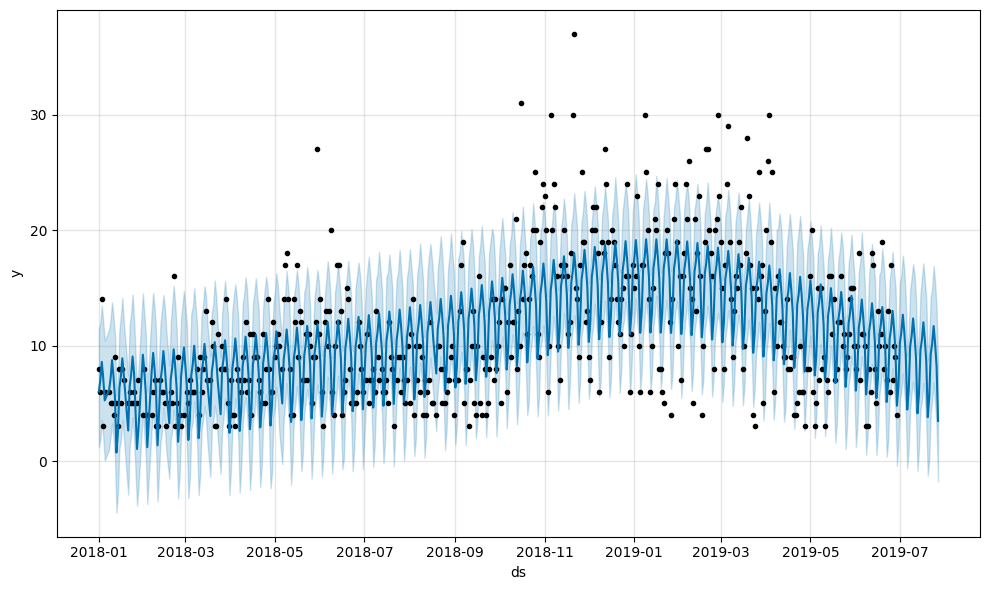

In [26]:
# Get the pickup location for the best model
sample_location_id = final_df.index[120]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>


/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/statsforecast/arima.py:861: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ray/anaconda3/lib/python3.8/site-packages/stat

location 237, algorithm arima, best error 1033.5825020926338


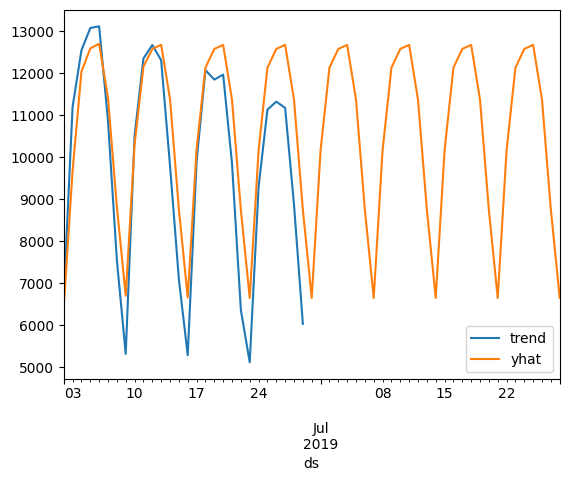

In [23]:
# Get the pickup location for the worst model
sample_location_id = final_df.index[len(final_df) - 2]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_location_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_location_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Make a prediction using the restored model.
prediction = (
    sample_model.forecast(2 * (FORECAST_LENGTH + 1))
    .reset_index()
    .set_index("ds")
)
prediction["trend"] = None
prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created inferences from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Append the prediction to the inferences
forecast_df = pd.concat([forecast_df, prediction])
    
# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_location_id]].error.values[0]
print(
    f"location {sample_location_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
if sample_algorithm == "arima":
    forecast_df[["trend", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)